In [5]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import glob
import itertools
import math
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

- row데이터 전처리

In [ ]:
df = pd.read_csv("전국대학및전문대학정보표준데이터.csv", encoding='cp949') 
df.head(3)

,학교명,학교 영문명,본분교구분명,대학구분명,학교구분명,설립형태구분명,시도코드,시도명,소재지도로명주소,소재지지번주소,도로명우편번호,소재지우편번호,홈페이지주소,대표전화번호,대표팩스번호,설립일자,기준연도,데이터기준일자,제공기관코드,제공기관명
0,강남대학교 융복합대학원,Kangnam Graduate School Of Convergence,본교,대학원,특수대학원,사립,41,경기도,"경기도 용인시 기흥구 강남로 40 (구갈동, 강남대학교)",NaN,16979,NaN,grd.kangnam.ac.kr,031-280-3500,031-280-3479,2018-03-01,2024,2025-01-08,B340014,한국대학교육협의회
1,강서대학교 교육대학원,"The Graduate School Of Education, GANGSEO UNIV...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회
2,강서대학교 사회복지대학원,"The Graduate School Of Social Welfare, GANGSEO...",본교,대학원,특수대학원,사립,11,서울특별시,"서울특별시 강서구 까치산로24길 47 (화곡동, 케이씨대학교)",NaN,7661,NaN,graduate.gangseo.ac.kr/,02-2600-2441,02-2600-2449,2002-10-30,2024,2025-01-08,B340014,한국대학교육협의회


In [55]:
# 1. 제외할 열 정의
exclude_cols = [
    "학교 영문명", "설립형태구분명", "소재지지번주소", "소재지우편번호",
    "홈페이지주소", "대표전화번호", "대표팩스번호",
    "기준연도", "데이터기준일자", "제공기관코드", "제공기관명"
]

# 2. 제외할 지역 조건 정의
exclude_regions = ["서울특별시", "경기도", "인천광역시"]
exclude_regions2 = ["경기도 의왕시 철도박물관로 157 (월암동, 한국교통대학교)"]

# 3. 지역 필터링 적용
df_filtered = df[
    (~df["시도명"].isin(exclude_regions)) &
    (~df["소재지도로명주소"].isin(exclude_regions2))
]

# 4. 열 제외 적용
df_filtered = df_filtered.drop(columns=exclude_cols)

# 5. 결과 저장
output_path = "전처리및제외지역.csv"
df_filtered.to_csv(output_path, index=False, encoding="cp949")

print("필터링 + 열 제외 완료! 결과는 CSV로 저장되었습니다.")


필터링 + 열 제외 완료! 결과는 CSV로 저장되었습니다.


In [ ]:
# 1. CSV 불러오기
df = pd.read_csv("전처리및제외지역.csv", encoding="cp949")

# 2. 우편번호 기준으로 묶어서 개수 카운트
# (우편번호 열 이름이 실제 CSV와 맞는지 확인 필요)
zipcode_counts = df["도로명우편번호"].value_counts()

# 3. 출력
print("=== 우편번호별 개수 ===")
print(zipcode_counts)

=== 우편번호별 개수 ===
도로명우편번호
54896    17
34134    16
54538    15
31460    14
61186    14
         ..
27600     1
25521     1
26034     1
25425     1
39257     1
Name: count, Length: 278, dtype: int64


In [ ]:
# 1. CSV 불러오기
df = pd.read_csv("전처리및제외지역.csv", encoding="cp949")

# 2. 우편번호 기준으로 중복 제거 (처음 등장한 행만 남김)
df_unique_zip = df.drop_duplicates(subset="도로명우편번호")

# 3. CSV로 저장
save_path = "중복제거.csv"
df_unique_zip.to_csv(save_path, index=False, encoding="cp949")

print(f"중복 제거된 우편번호 데이터가 저장되었습니다: {save_path}")


중복 제거된 우편번호 데이터가 저장되었습니다: 중복제거.csv


In [ ]:
# 1. CSV 불러오기
df = pd.read_csv("중복제거.csv", encoding="cp949")

# 2. 주소에서 카운트할 '지역' 추출 함수
def extract_count_region(address):
    # 공백으로 분리
    parts = address.split()
    # 광역시/특별자치도
    if parts[0].endswith(("광역시", "특별자치도", "특별자치시")):
        return parts[0]
    # 도 단위
    elif parts[0].endswith("도"):
        # 도 뒤에 오는 시/군 이름
        if len(parts) > 1:
            return parts[1]
        else:
            return parts[0]  # 시/군이 없으면 도 이름
    else:
        return parts[0]  # 예외 처리

# 3. 새로운 컬럼 생성
df["카운트지역"] = df["소재지도로명주소"].apply(extract_count_region)

# 4. 지역별 카운트
region_counts = df["카운트지역"].value_counts()

# 5. 출력
print("=== 카운트 지역별 개수 ===")
print(region_counts)


=== 카운트 지역별 개수 ===
카운트지역
부산광역시      30
강원특별자치도    26
전북특별자치도    20
대전광역시      19
광주광역시      17
대구광역시      16
경산시        11
천안시        11
청주시         9
진주시         7
창원시         6
울산광역시       6
아산시         5
세종특별자치시     5
제주특별자치도     5
무안군         4
김해시         4
포항시         4
구미시         4
나주시         4
경주시         4
목포시         3
양산시         3
순천시         3
제천시         3
영주시         3
논산시         3
안동시         3
칠곡군         2
김천시         2
공주시         2
여수시         2
거창군         2
영천시         2
충주시         2
음성군         2
영암군         2
홍성군         1
사천시         1
담양군         1
곡성군         1
옥천군         1
청양군         1
예천군         1
남해군         1
문경시         1
보령시         1
당진시         1
광양시         1
상주시         1
예산군         1
영광군         1
영동군         1
금산군         1
괴산군         1
부여군         1
서산시         1
거제시         1
고령군         1
Name: count, dtype: int64


In [ ]:
# 필터링 조건 (학교명, 학교종류)
target_conditions = [
    ("연암대학교", "전문대학"),
    ("백석문화대학교", "전문대학"),
    ("국립공주대학교 대학원", "일반대학원"),
    ("고신대학교 신학대학원", "특수대학원"),
    ("글로벌사이버대학교", "사이버대학(대학)"),
    ("나사렛대학교", "대학교"),
    ("남서울대학교", "대학교"),
    ("단국대학교 _제2캠퍼스", "대학교"),
    ("상명대학교 _제2캠퍼스", "대학교"),
    ("한국기술교육대학교", "대학교"),
    ("한국기술교육대학교 대학원", "일반대학원")
]

# CSV 경로
path = r"C:\Users\yeye0\Desktop\천안시\학교\**\*.csv"
files = glob.glob(path, recursive=True)

yearly_data = {}

for file in files:
    # 파일명에서 연도 추출
    basename = os.path.basename(file)
    year = basename.split("_")[-1].replace(".csv", "")

    # CSV 읽기
    try:
        df = pd.read_csv(file, header=None, encoding="utf-8")
    except:
        df = pd.read_csv(file, header=None, encoding="cp949")

    # 헤더 행 탐색 (학교명 포함)
    for i in range(5):
        row = df.iloc[i].astype(str).str.strip()
        if any("학교" in x or "대학원" in x for x in row):
            df.columns = row
            df = df[i+1:].reset_index(drop=True)
            break

    # 컬럼명 정리 (공백, 따옴표, 줄바꿈 제거)
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('"', '')
    df.columns = df.columns.str.replace("\n", "", regex=False)

    # 학교명 컬럼 통일
    if "학교" in df.columns:
        df.rename(columns={"학교": "학교명"}, inplace=True)
    elif "대학원명" in df.columns:
        df.rename(columns={"대학원명": "학교명"}, inplace=True)
    elif "학교명" not in df.columns:
        print(f"⚠️ {file} → 학교명 컬럼 없음")
        continue

    # 학교종류 없으면 파일명 기반으로 생성
    if "학교종류" not in df.columns:
        fname_lower = file.lower()
        if "대학원" in fname_lower:
            df["학교종류"] = "대학원"
        elif "전문대" in fname_lower:
            df["학교종류"] = "전문대학"
        else:
            df["학교종류"] = "대학"

    # 공백 제거
    df["학교명"] = df["학교명"].astype(str).str.strip()
    df["학교종류"] = df["학교종류"].astype(str).str.strip()

    # 필터링
    mask = pd.Series(False, index=df.index)
    for school, gubun in target_conditions:
        mask |= (df["학교명"] == school) & (df["학교종류"] == gubun)

    filtered_df = df[mask]

    if filtered_df.empty:
        print(f"⚠️ {file} ({year}) → 조건에 맞는 데이터 없음")
        continue

    # 대학/전문대학 vs 대학원 컬럼 처리
    if filtered_df["학교종류"].iloc[0] in ["대학교", "전문대학", "사이버대학(대학)"]:
        # 대학/전문대학: 모집인원, 입학자만
        cols_to_keep = ["모집인원", "입학자"]
        filtered_df = filtered_df[["기준연도", "학교종류", "학교명"] + cols_to_keep]
    else:
        # 대학원: 지원자 → 모집인원, 모집인원, 입학자만
        if "지원자" in filtered_df.columns:
            filtered_df.rename(columns={"지원자": "모집인원"}, inplace=True)
        cols_to_keep = ["모집인원", "입학자"]
        filtered_df = filtered_df[["기준연도", "학교종류", "학교명"] + cols_to_keep]

    # 연도별 데이터 합치기
    if year not in yearly_data:
        yearly_data[year] = filtered_df
    else:
        yearly_data[year] = pd.concat([yearly_data[year], filtered_df], ignore_index=True)

# 연도별 CSV 저장
output_dir = r"C:\Users\yeye0\Desktop\천안시"
os.makedirs(output_dir, exist_ok=True)
for year, df in yearly_data.items():
    if not df.empty:
        output_file = os.path.join(output_dir, f"신입생 충원 현황_{year}_filtered.csv")
        df.to_csv(output_file, index=False, encoding="utf-8-sig")
        print(f"✅ 저장 완료: {output_file}")
    else:
        print(f"⚠️ {year}년도 데이터 없음")


✅ 저장 완료: C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_2020_filtered.csv
✅ 저장 완료: C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_2021_filtered.csv
✅ 저장 완료: C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_2022_filtered.csv
✅ 저장 완료: C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_2023_filtered.csv
✅ 저장 완료: C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_2024_filtered.csv


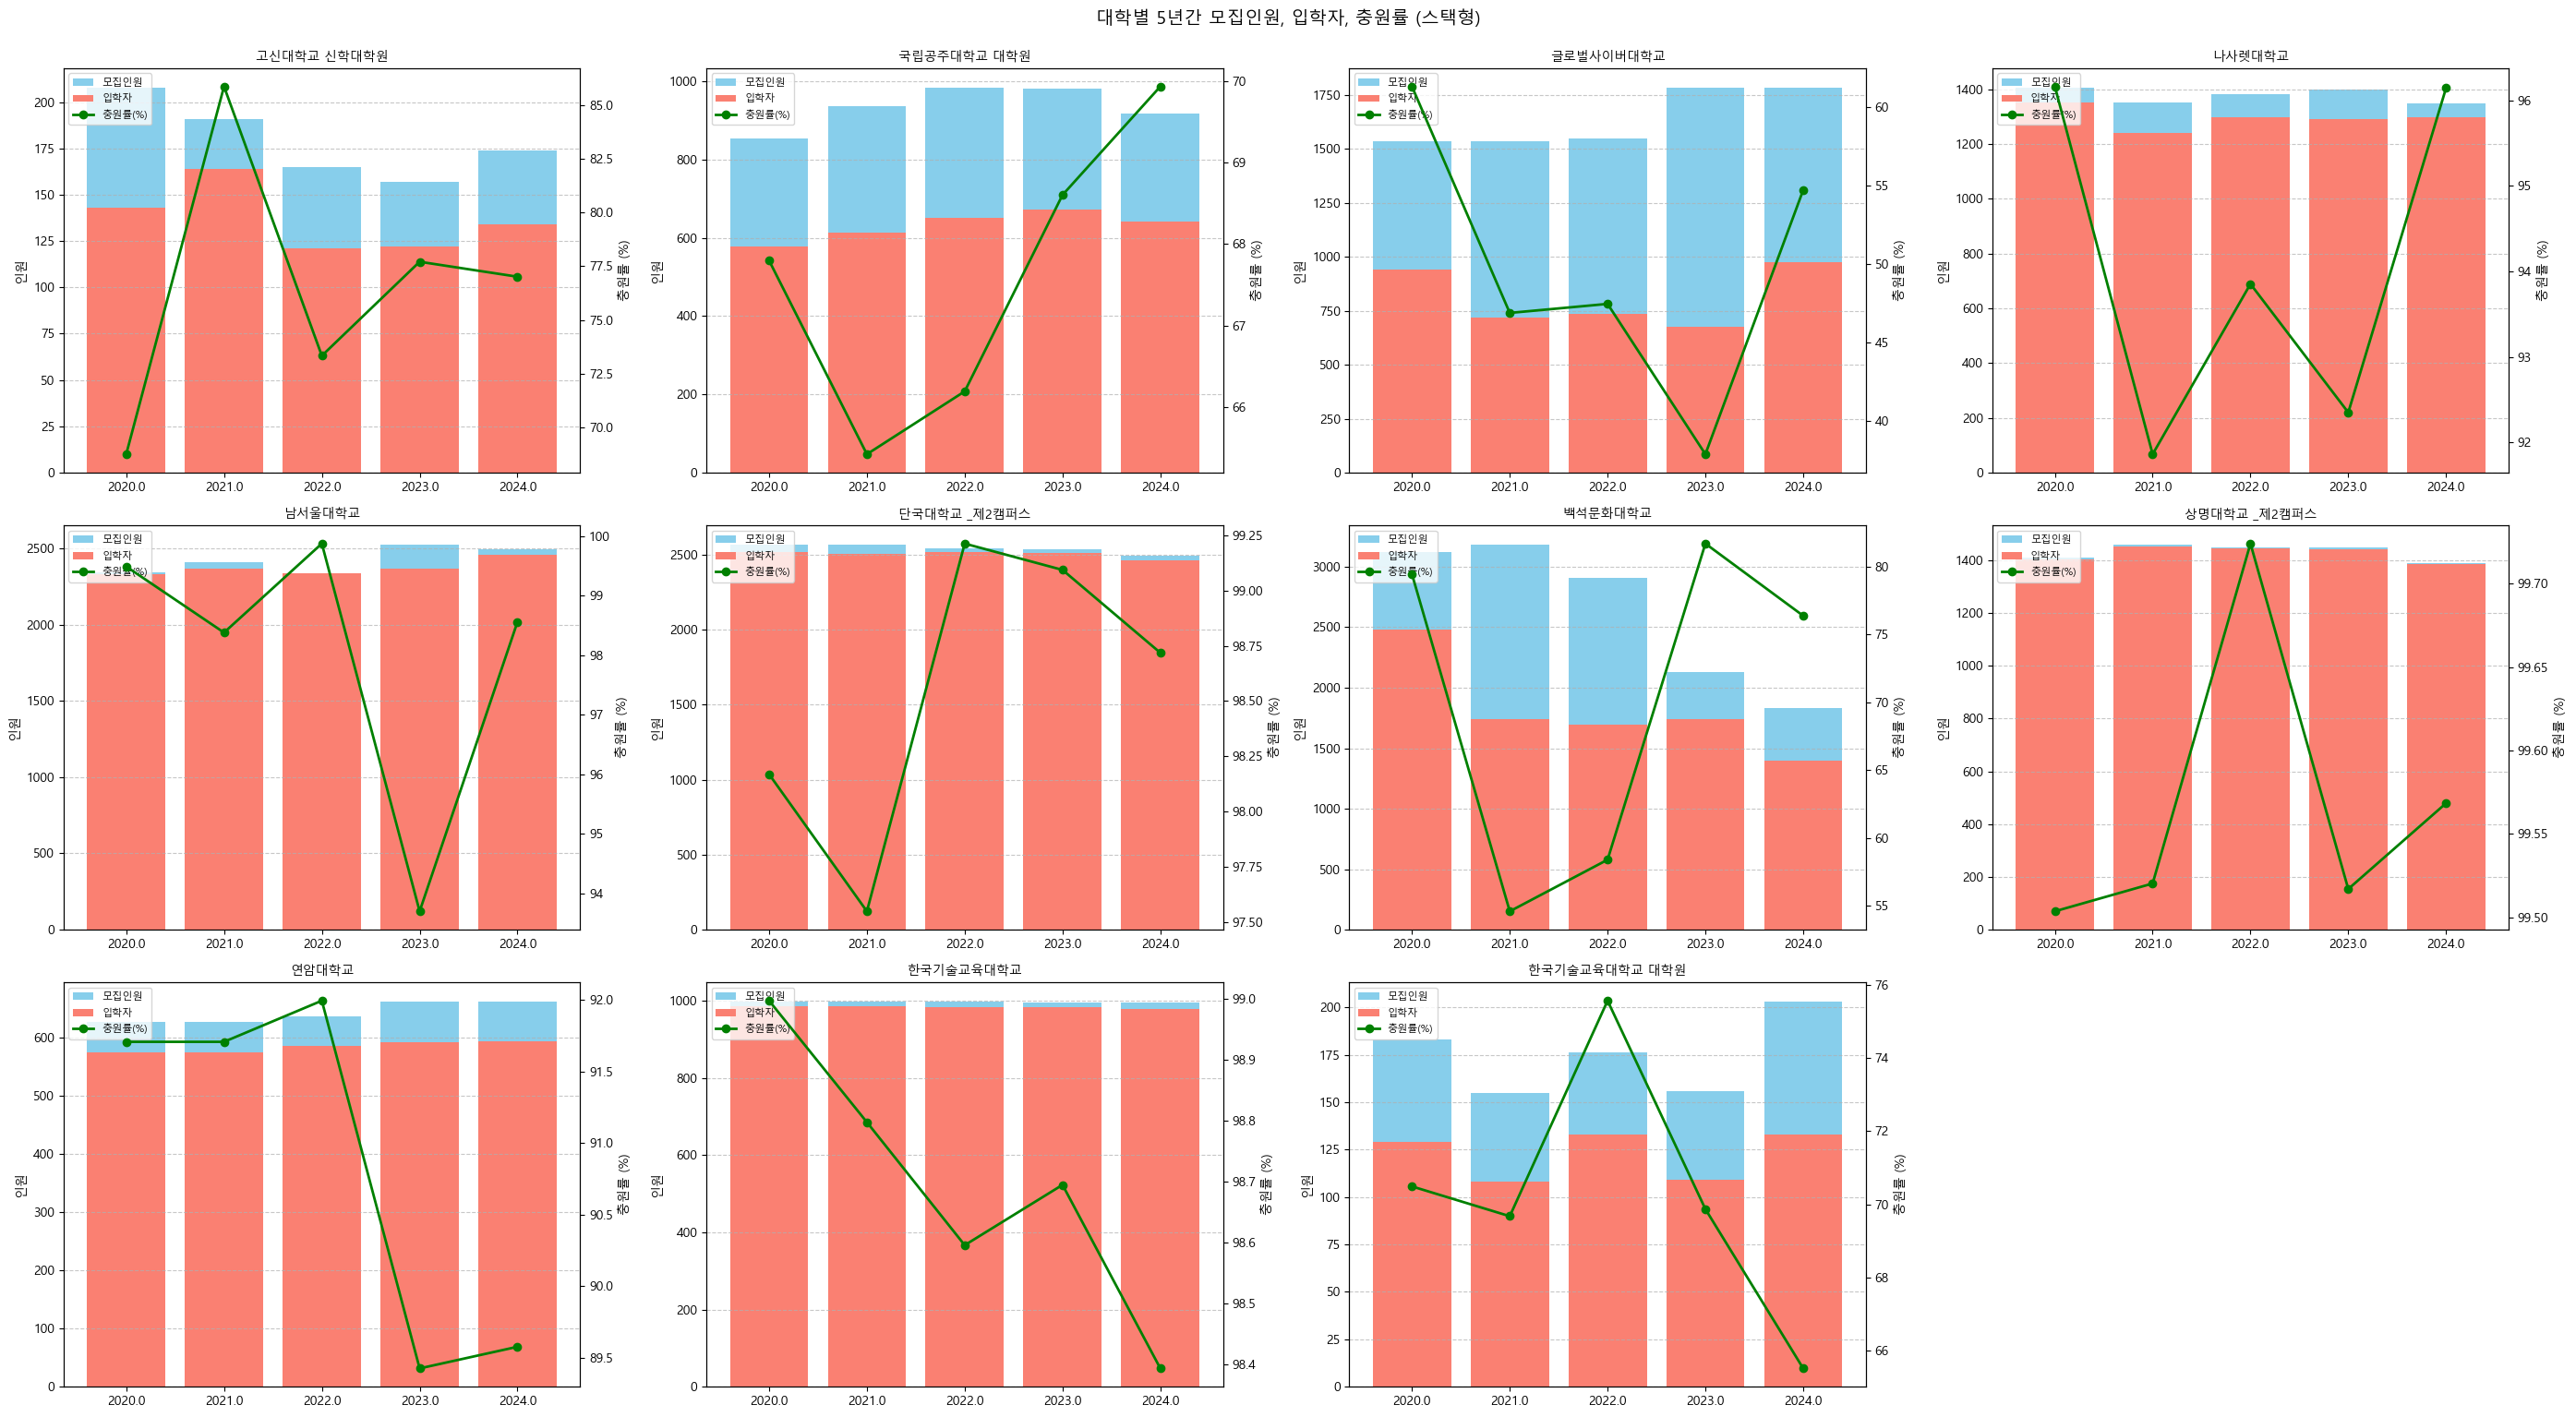

In [61]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import math

# 1. 모든 CSV 파일 읽어오기
path_pattern = r"C:\Users\yeye0\Desktop\천안시\신입생 충원 현황_*_filtered.csv"
files = glob.glob(path_pattern)

# 여러 파일 합치기
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

# '대학'만 필터링
universities = df[df['학교종류'].str.contains("대학")]

# 연도별, 학교별 모집인원과 입학자 합계
grouped = universities.groupby(['학교명', '기준연도']).agg({'모집인원':'sum', '입학자':'sum'}).reset_index()
grouped['충원률'] = grouped['입학자'] / grouped['모집인원'] * 100

# 학교 리스트
school_list = grouped['학교명'].unique()
num_schools = len(school_list)

cols = 4
rows = math.ceil(num_schools / cols)

fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 5*rows))
axes = axes.flatten()

for i, school in enumerate(school_list):
    ax1 = axes[i]
    data = grouped[grouped['학교명'] == school]
    x = np.arange(len(data['기준연도']))
    
    # 스택형 막대그래프
    ax1.bar(x, data['모집인원'], label='모집인원', color='skyblue')
    ax1.bar(x, data['입학자'], label='입학자', color='salmon')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(data['기준연도'])
    ax1.set_ylabel('인원')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 충원률 선 그래프
    ax2 = ax1.twinx()
    ax2.plot(x, data['충원률'], color='green', marker='o', linestyle='-', linewidth=2, label='충원률(%)')
    ax2.set_ylabel('충원률 (%)')

    # 범례 합치기
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=8, loc='upper left')

    ax1.set_title(school, fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('대학별 5년간 모집인원, 입학자, 충원률 (스택형)', fontsize=14, y=1.02)
plt.show()

[완료] 선 그래프 저장: C:\Users\yeye0\Desktop\천안시\학령인구합계.png


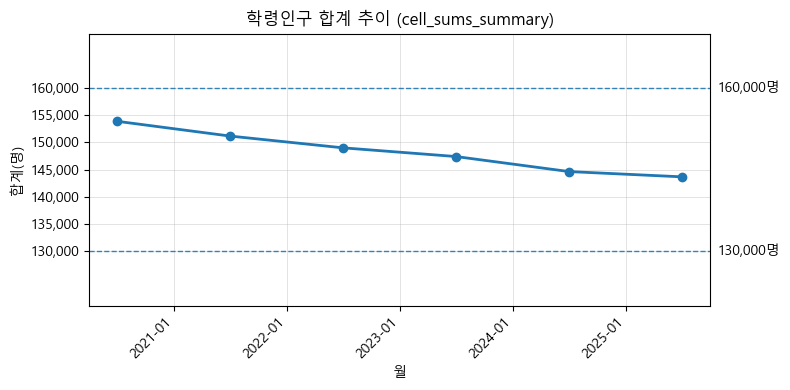

In [63]:
# 학령인구합계 그래프화

import re
import platform
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

# ===== 사용자 설정 =====
CSV_PATH  = r"C:\Users\yeye0\Desktop\천안시\cell_sums_summary.csv"
VALUE_COL = "sum"   # 그릴 값(기본: 합계)
TITLE     = "학령인구 합계 추이 (cell_sums_summary)"
REF_LINES = [160_000, 130_000]  # y축 기준선(명)
# =======================

def set_korean_font():
    try:
        sysname = platform.system()
        if sysname == "Windows":
            plt.rcParams["font.family"] = "Malgun Gothic"
        elif sysname == "Darwin":  # macOS
            plt.rcParams["font.family"] = "AppleGothic"
        plt.rcParams["axes.unicode_minus"] = False
    except Exception:
        pass

def parse_year_month_from_filename(name: str):
    """
    파일명에서 연/월을 찾아 datetime으로 반환. 실패 시 None.
    허용 예: 2020.7, 2020-07, 2020_07, 2020 7, 2020년 7월, (2020.07) 등
    """
    # 1) "2020년 7월"
    m = re.search(r"(20\d{2})\s*년\s*(1[0-2]|0?[1-9])\s*월", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    # 2) "2020-07", "2020.7", "2020_7", "2020 07"
    m = re.search(r"(20\d{2})[.\-_\s]+(1[0-2]|0?[1-9])", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    # 3) 괄호 안
    m = re.search(r"\((20\d{2})[.\-_\s]*(1[0-2]|0?[1-9])\)", name)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=y, month=mo, day=1)
    return None

def load_summary(csv_path: str) -> pd.DataFrame:
    p = Path(csv_path)
    if not p.exists():
        raise FileNotFoundError(f"CSV를 찾을 수 없습니다: {p}")
    # UTF-8-SIG 권장, 실패 시 cp949
    try:
        df = pd.read_csv(p, encoding="utf-8-sig")
    except UnicodeDecodeError:
        df = pd.read_csv(p, encoding="cp949")
    if "filename" not in df.columns or VALUE_COL not in df.columns:
        raise ValueError(f"'filename' 또는 '{VALUE_COL}' 컬럼이 없습니다. 실제 컬럼: {list(df.columns)}")
    return df

def sort_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["__date__"] = df["filename"].apply(lambda s: parse_year_month_from_filename(str(s)))
    # 날짜 파싱 성공이 절반 이상이면 날짜 기준 정렬
    if df["__date__"].notna().mean() >= 0.5:
        df = df.sort_values("__date__")
    # 수치형 변환
    df[VALUE_COL] = pd.to_numeric(df[VALUE_COL], errors="coerce")
    return df

def plot_line(df: pd.DataFrame, title: str, ref_lines=None, fix_ylim=None, fixed_ticks=None):
    """
    ref_lines: 수평 기준선 값 리스트(예: [160000, 130000])
    fix_ylim: (ymin, ymax)로 y축 구간 고정하고 싶을 때 사용 (예: (120000, 170000))
    fixed_ticks: y축 눈금을 고정 리스트로 직접 지정할 때 사용 (예: [120000, 130000, ..., 170000])
    """
    set_korean_font()
    fig, ax = plt.subplots(figsize=(8, 4))

    # 축/데이터 준비
    if df["__date__"].notna().any():
        d_used = df[df["__date__"].notna()]
        yvals = d_used[VALUE_COL].astype(float).values
        ax.plot(d_used["__date__"], d_used[VALUE_COL], marker="o", linewidth=2)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.set_xlabel("월")
    else:
        yvals = pd.to_numeric(df[VALUE_COL], errors="coerce").values
        ax.plot(df["filename"], df[VALUE_COL], marker="o", linewidth=2)
        ax.set_xlabel("파일")

    ax.set_title(title)
    ax.set_ylabel("합계(명)")
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
    plt.xticks(rotation=45, ha="right")

    # --- 기준선 ---
    if ref_lines:
        for v in ref_lines:
            ax.axhline(y=v, linestyle="--", linewidth=1, alpha=0.9)
            ax.annotate(f"{v:,.0f}명",
                        xy=(1, v), xycoords=("axes fraction", "data"),
                        xytext=(5, 0), textcoords="offset points", va="center")

    # --- y축 범위/눈금 ---
    clean = yvals[~np.isnan(yvals)]
    if fix_ylim is not None:
        ax.set_ylim(*fix_ylim)
    else:
        # 데이터와 기준선을 모두 포함하도록 자동 설정(여유 5%)
        ymin = min(clean.min() if clean.size else np.inf,
                   min(ref_lines) if ref_lines else np.inf)
        ymax = max(clean.max() if clean.size else -np.inf,
                   max(ref_lines) if ref_lines else -np.inf)
        if np.isfinite(ymin) and np.isfinite(ymax):
            pad = max((ymax - ymin) * 0.05, 1.0)
            ax.set_ylim(ymin - pad, ymax + pad)

    # y축 눈금에 기준선 값 포함
    if fixed_ticks is not None:
        ax.set_yticks(fixed_ticks)
    else:
        ticks = list(ax.get_yticks())
        if ref_lines:
            for v in ref_lines:
                if v not in ticks:
                    ticks.append(v)
        ax.set_yticks(sorted(ticks))

    plt.tight_layout()
    out_png = str(Path(CSV_PATH).with_name("학령인구합계.png"))
    plt.savefig(out_png, dpi=200)
    print(f"[완료] 선 그래프 저장: {out_png}")
    plt.show()

def main():
    df = load_summary(CSV_PATH)
    df_sorted = sort_for_plot(df)

    # (기본) 기준선만 추가, y범위는 자동
    #plot_line(df_sorted, TITLE, ref_lines=REF_LINES)

    # (선택) y축을 아예 고정하고 싶다면 아래 한 줄로 대체:
    plot_line(df_sorted, TITLE,
            ref_lines=REF_LINES,
            fix_ylim=(120_000, 170_000),
            fixed_ticks=list(range(130_000, 160_001, 5_000)))
    
if __name__ == "__main__":
    main()


- 변수 데이터 전처리

In [ ]:
# 원본 CSV 불러오기
df = pd.read_csv(r"C:\Users\yeye0\Desktop\천안시\변수데이터\국토교통부_전국 버스정류장 위치정보.csv", encoding="cp949")

# '도시명'이 '충청남도 천안시'인 행만 필터링
df_cheonan = df[df["도시명"] == "충청남도 천안시"]

# 결과 저장
df_cheonan.to_csv(r"C:\Users\yeye0\Desktop\천안시\변수데이터\국토교통부_전국 버스정류장 위치정보.csv", index=False, encoding="utf-8-sig")

print("필터링된 데이터 개수:", len(df_cheonan))


In [ ]:
# 원본 엑셀 파일 경로
excel_file = r"C:\Users\yeye0\Desktop\천안시\변수데이터\병원정보서비스.xlsx"

# CSV 저장 경로
csv_file = r"C:\Users\yeye0\Desktop\천안시\변수데이터\병원정보서비스.csv"

# 1. 엑셀 → CSV 변환
df = pd.read_excel(excel_file)

# CSV로 저장 (utf-8-sig로 저장하면 한글 깨짐 방지됨)
df.to_csv(csv_file, index=False, encoding="utf-8-sig")

# 2. 다시 CSV 읽기 (혹은 df 바로 사용 가능)
df_csv = pd.read_csv(csv_file, encoding="utf-8-sig")

# 3. '시군구코드명'이 천안서북구 or 천안동남구인 행만 추출
df_cheonan = df_csv[df_csv["시군구코드명"].isin(["천안서북구", "천안동남구"])]

# 4. 결과 저장
output_file = r"C:\Users\yeye0\Desktop\천안시\변수데이터\병원정보서비스.csv"
df_cheonan.to_csv(output_file, index=False, encoding="utf-8-sig")

print("필터링된 데이터 개수:", len(df_cheonan))
print(f"저장 완료: {output_file}")

In [ ]:
#천안시 초/중/고등학교 위치데이터 전처리

from __future__ import annotations
from pathlib import Path
import json
import pandas as pd

# 0) 경로 설정
BASE_DIR = Path(r"C:\공모전\2025천안\초중등학교 데이터")
OUTPUT_DIR = BASE_DIR / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_CSV = OUTPUT_DIR / "천안_초중학교_지번주소_추출.csv"

# 1) 후보 파일 찾기: CSV/JSON 모두 스캔 (이름은 유연하게)
def find_input_file(base: Path) -> Path:
    # 우선 '전국초중등학교위치표준데이터' 패턴 우대
    prefer = sorted(list(base.glob("전국초중등학교위치표준데이터.*")))
    if prefer:
        # CSV 우선 → JSON
        prefer = sorted(prefer, key=lambda p: (p.suffix.lower() != ".csv", p.name))
        return prefer[0]
    # 그 외 CSV/JSON 중 아무거나 (CSV 우선)
    candidates = sorted(list(base.glob("*.csv"))) + sorted(list(base.glob("*.json")))
    if not candidates:
        raise FileNotFoundError(f"입력 파일이 없습니다: {base}")
    # CSV 우선
    candidates = sorted(candidates, key=lambda p: (p.suffix.lower() != ".csv", p.name))
    return candidates[0]

# 2) 로더: CSV(utf-8-sig → utf-8 → cp949), JSON은 다양한 형태 지원
def read_csv_any(path: Path) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8-sig", "utf-8", "cp949"):
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"CSV 로딩 실패: {path} / 마지막 오류: {last_err}")

def read_json_any(path: Path) -> pd.DataFrame:
    # ① 표준: 리스트[딕셔너리] (records 배열만)
    try:
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
    except UnicodeDecodeError:
        with path.open("r", encoding="cp949") as f:
            data = json.load(f)

    # 형태별 처리
    # case A) 최상위가 리스트: 바로 DataFrame
    if isinstance(data, list):
        return pd.DataFrame(data)

    # case B) 딕셔너리: 'records' 키가 있는 공식 포맷
    if isinstance(data, dict):
        # 가장 흔한 구조: {"fields":[...], "records":[{...},{...}, ...]}
        if "records" in data and isinstance(data["records"], list):
            return pd.DataFrame(data["records"])
        # 다른 변형: {"data":[{...}], "fields":[...]} 등
        for key in ("data", "rows", "result", "items"):
            if key in data and isinstance(data[key], list) and data[key] and isinstance(data[key][0], dict):
                return pd.DataFrame(data[key])

    # case C) 판다스의 NDJSON 라인 모드로 재시도
    try:
        return pd.read_json(path, lines=True)
    except Exception:
        pass

    # 실패 시 힌트 출력
    raise ValueError(
        f"JSON 구조를 해석할 수 없습니다: {path}\n"
        f"예상 구조: 리스트[딕셔너리] 또는 {{'records': [{{...}}, ...]}}"
    )

def read_any(path: Path) -> pd.DataFrame:
    if path.suffix.lower() == ".csv":
        return read_csv_any(path)
    elif path.suffix.lower() == ".json":
        return read_json_any(path)
    else:
        raise ValueError(f"지원하지 않는 확장자: {path.suffix}")

# 3) 원시 컬럼 그대로 사용: (학교ID, 학교명, 학교급구분, 소재지지번주소, 위도, 경도)
REQUIRED = ["학교ID", "학교명", "학교급구분", "소재지지번주소", "위도", "경도"]

def validate_required_columns(df: pd.DataFrame) -> None:
    missing = [c for c in REQUIRED if c not in df.columns]
    if missing:
        sample_cols = list(df.columns)[:30]
        raise KeyError(
            f"필수 컬럼 누락: {missing}\n"
            f"- 데이터에 실제로 있는 컬럼(일부): {sample_cols}\n"
            f"- JSON이라면 'records' 배열이 평탄화되었는지 확인하세요."
        )

# 4) 천안 필터 + 초/중 필터 + 숫자화/중복제거
def filter_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    # 정확히 원시 컬럼명을 유지
    use = df.copy()
    # 필터: 학교급구분
    mask_level = use["학교급구분"].astype(str).isin(["초등학교", "중학교","고등학교"])
    # 필터: 소재지지번주소에 '천안' 포함
    mask_addr = use["소재지지번주소"].astype(str).str.contains("천안", na=False)
    out = use.loc[mask_level & mask_addr, REQUIRED].copy()

    # 위경도 숫자형 변환
    out["위도"] = pd.to_numeric(out["위도"], errors="coerce")
    out["경도"] = pd.to_numeric(out["경도"], errors="coerce")
    out = out.dropna(subset=["위도", "경도"])

    # 학교ID 기준 중복 제거
    out = out.drop_duplicates(subset=["학교ID"]).reset_index(drop=True)

    # 정렬(가독성)
    out = out.sort_values(by=["학교명", "학교ID"]).reset_index(drop=True)
    return out

def main():
    print("[INFO] 입력 폴더:", BASE_DIR)
    src = find_input_file(BASE_DIR)
    print("[INFO] 선택된 파일:", src.name)
    df_raw = read_any(src)
    print(f"[INFO] 원본 shape={df_raw.shape}")

    validate_required_columns(df_raw)

    df_out = filter_and_clean(df_raw)
    print(f"[INFO] 필터 후 shape={df_out.shape}")

    df_out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
    print("[DONE] 저장:", OUTPUT_CSV)

    with pd.option_context("display.max_colwidth", 120):
        print("\n[샘플 5건]\n", df_out.head(5).to_string(index=False))

if __name__ == "__main__":
    main()


In [ ]:
# 연령별인구_읍면동_5세구간
import re
import pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\공모전\2025천안\연령별 인구수")
OUT_DIR  = BASE_DIR / "outputs_5y"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def coerce_int(x):
    if pd.isna(x): return 0
    s = str(x).strip()
    if s in {"", "-", "–", "—", "NaN", "nan"}: return 0
    s = re.sub(r"[^\d]", "", s)
    return int(s) if s else 0

def five_year_bin(age):
    try:
        a = int(age)
    except:
        return None
    if a >= 85: return "85+"
    lo = (a//5)*5
    return f"{lo}-{lo+4}"

def std_gender(v):
    s = str(v).strip().lower()
    if s in {"남","남자","m","male"}: return "남"
    if s in {"여","여자","f","female"}: return "여"
    return None  # 계/기타는 제외

def parse_year_month_from_filename(path: Path):
    name = path.stem
    m = re.search(r"(20\d{2})[^\d]?(\d{1,2})\s*월", name)
    if m: return int(m.group(1)), int(m.group(2))
    m = re.search(r"(20\d{2})(0[1-9]|1[0-2])", name)
    if m: return int(m.group(1)), int(m.group(2))
    m = re.search(r"(20\d{2})", name)
    return (int(m.group(1)), 7) if m else (None, None)

def parse_file(path: Path) -> pd.DataFrame:
    # 1) 시트2를 다중헤더로 읽기 (2020 샘플 기준 6·7행이 헤더라 header=[5,6])
    df = pd.read_excel(path, sheet_name=1, header=[5,6], engine="openpyxl")

    # 2) MultiIndex → 상단 레벨만 사용, 공백 제거
    top_names = [re.sub(r"\s+", "", str(top).strip()) for top, _ in df.columns.to_list()]
    df.columns = top_names

    # 3) 첫 두 컬럼을 강제로 이름 지정 (둘 다 '연령'으로 들어오는 경우가 있어 인덱스로 지정)
    cols = list(df.columns)
    if len(cols) < 3:
        return pd.DataFrame()
    cols[0], cols[1] = "연령라벨", "성별"
    df.columns = cols

    # 4) 연령라벨을 ffill해서 남/여 행에도 연령 정보 채움 (핵심!)
    if "연령라벨" not in df.columns or "성별" not in df.columns:
        return pd.DataFrame()
    df["연령라벨"] = df["연령라벨"].ffill()

    # 5) melt 대상(읍면동 열) 선정: 시/구 합계 열 제거
    drop_totals = {"천안시", "천안시동남구", "천안시서북구"}
    value_cols = [c for c in df.columns if c not in {"연령라벨","성별"} and c not in drop_totals]

    # 6) wide → long
    long = df.melt(id_vars=["연령라벨","성별"], value_vars=value_cols,
                   var_name="읍면동", value_name="인구수")

    # 7) 정제
    long["성별"] = long["성별"].apply(std_gender)             # 남/여만 남기기
    long = long[long["성별"].notna()]
    long["인구수"] = long["인구수"].map(coerce_int)
    long["연령"] = long["연령라벨"].astype(str).str.extract(r"(\d+)").astype(float)
    long["연령5세구간"] = long["연령"].map(five_year_bin)
    long = long.dropna(subset=["연령5세구간"])
    long["읍면동"] = long["읍면동"].astype(str).str.replace(r"\s+", "", regex=True)

    # 8) 집계
    out = (long.groupby(["읍면동","성별","연령5세구간"], as_index=False)["인구수"].sum())

    # 9) 메타(연/월)
    y, m = parse_year_month_from_filename(path)
    out["year"] = y
    out["month"] = m
    out["yyyymm"] = f"{y:04d}{m:02d}" if y and m else None
    return out

# ========= 실행 루프 =========
all_parts = []
for f in sorted(BASE_DIR.glob("*.xlsx")):
    if f.name.startswith("~$"):   # 엑셀 임시파일 무시
        continue
    print(f"[INFO] 처리중: {f.name}")
    try:
        part = parse_file(f)
        if part.empty:
            print(f"[WARN] {f.name} 결과 없음")
            continue
        yyyymm = part["yyyymm"].iloc[0] or str(part["year"].iloc[0])
        out_path = OUT_DIR / f"연령별인구_읍면동_5세구간_{yyyymm}.csv"
        part.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"[DONE] 저장 → {out_path}")
        all_parts.append(part)
    except Exception as e:
        print(f"[ERROR] {f.name}: {e}")

# ========= 통합 저장 =========
if all_parts:
    full = pd.concat(all_parts, ignore_index=True)
    order = [f"{i}-{i+4}" for i in range(0,85,5)] + ["85+"]
    full["연령5세구간"] = pd.Categorical(full["연령5세구간"], categories=order, ordered=True)
    full = full.sort_values(["year","month","읍면동","성별","연령5세구간"])
    full.to_csv(OUT_DIR / "연령별인구_읍면동_5세구간_all.csv", index=False, encoding="utf-8-sig")
    print(f"[DONE] 통합 저장 → {OUT_DIR / '연령별인구_읍면동_5세구간_all.csv'}")
else:
    print("[알림] 생성된 결과가 없습니다. (헤더 행이 파일마다 다르면 header=[6,7] 등으로 조정해보세요.)")


## 모델링

In [24]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import glob
import itertools
import ast
import folium
from folium.features import GeoJsonTooltip
from IPython.display import display
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# -----------------------------
# 파일 경로
# -----------------------------
DATA_DIR = r"C:\Users\yeye0\Desktop\천안시"
PATHS = {
    "boundary_csv": os.path.join(DATA_DIR, "천안시경계\천안시_경계.csv"),
    "universities": os.path.join(DATA_DIR, "변수데이터\천안시_대학.csv"),
    "schools": os.path.join(DATA_DIR, "변수데이터\천안시_초중고.csv"),
    "busstops": os.path.join(DATA_DIR, "변수데이터\천안시_버스정류장.csv"),
    "hospitals": os.path.join(DATA_DIR, "변수데이터\천안시_병원.csv"),
    "univ_fill": os.path.join(DATA_DIR, "신입생 충원 현황_*_filtered.csv"),
    "target_pop": os.path.join(DATA_DIR, "변수데이터\천안시_인구.csv"),
    "migration": os.path.join(DATA_DIR, "변수데이터\천안시_인구이동.csv"),
    "fiveyears": os.path.join(DATA_DIR, "변수데이터\나이대별\연령별인구_*.csv")
    
}

# 경계 데이터
boundary_df = pd.read_csv(PATHS["boundary_csv"])

# 위치 데이터
universities_df = pd.read_csv(PATHS["universities"])
schools_df = pd.read_csv(PATHS["schools"])
busstops_df = pd.read_csv(PATHS["busstops"])
hospitals_df = pd.read_csv(PATHS["hospitals"])

# 입학 충원률 데이터 (여러 파일 합치기)
univ_fill_files = glob.glob(PATHS["univ_fill"])
univ_fill_df = pd.concat([pd.read_csv(f) for f in univ_fill_files], ignore_index=True)

# 인구/이동 데이터
pop_df = pd.read_csv(PATHS["target_pop"])
migration_df = pd.read_csv(PATHS["migration"])

# 연령별 인구 데이터 (여러 파일 합치기)
fiveyears_files = glob.glob(PATHS["fiveyears"])
fiveyears_df = pd.concat([pd.read_csv(f) for f in fiveyears_files], ignore_index=True)

In [18]:
#  '_WKT' 컬럼을 Polygon으로 변환
boundary_df['geometry'] = boundary_df['_WKT'].apply(wkt.loads)

#  GeoDataFrame 생성
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry='geometry')
gdf_boundary.set_crs(epsg=4326, inplace=True)  # WGS84 좌표계
gdf_boundary.head(3)

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,_WKT,geometry
0,44131101,Daeheung-dong,대흥동,"POLYGON((127.14961448604429 36.81205091429975,...","POLYGON ((127.14961 36.81205, 127.14961 36.812..."
1,44131102,Seonghwang-dong,성황동,"POLYGON((127.1499015944674 36.81193441921396,1...","POLYGON ((127.14990 36.81193, 127.14990 36.811..."
2,44131103,Munhwa-dong,문화동,"POLYGON((127.1499015944674 36.81193441921396,1...","POLYGON ((127.14990 36.81193, 127.14990 36.811..."


In [30]:
# -----------------------------
# 1) 경계 CSV 불러오기
# -----------------------------
boundary_df = pd.read_csv(PATHS["boundary_csv"])
boundary_df['geometry'] = boundary_df['_WKT'].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry='geometry')
gdf_boundary.set_crs(epsg=4326, inplace=True)

# -----------------------------
# 2) 대학 위치 CSV 불러오기
# -----------------------------
univ_loc_df = pd.read_csv(PATHS["universities"])
gdf_univ_loc = gpd.GeoDataFrame(
    univ_loc_df,
    geometry=[Point(xy) for xy in zip(univ_loc_df['Longitude'], univ_loc_df['Latitude'])],
    crs="EPSG:4326"
)

# -----------------------------
# 3) 공간 연산을 통한 대학별 읍면동 정보 추가 
# -----------------------------
# 읍면동 경계와 대학 위치 GeoDataFrame을 공간 조인(Spatial Join)
gdf_univ_with_emd = gpd.sjoin(gdf_univ_loc, gdf_boundary, how="inner", predicate="within")

# -----------------------------
# 4) 읍면동별 대학 수 집계
# -----------------------------
# 공간 조인된 데이터프레임에서 'EMD_KOR_NM'별로 고유한 학교명 개수 집계
univ_count = gdf_univ_with_emd.groupby('EMD_KOR_NM')['학교명'].nunique().reset_index()
univ_count = univ_count.rename(columns={'학교명': '대학수'})

# -----------------------------
# 5) 경계 GeoDataFrame에 대학 수 병합
# -----------------------------
gdf_boundary = gdf_boundary.merge(univ_count, on='EMD_KOR_NM', how='left')
gdf_boundary['대학수'] = gdf_boundary['대학수'].fillna(0)

# -----------------------------
# 6) Folium 지도 생성 
# -----------------------------
m = folium.Map(
    location=[36.8, 127.15],
    zoom_start=11,
    tiles='https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  # 구글 지도
    attr='Google'
)

# 경계 GeoJson 표시 + 대학 수 툴팁
tooltip = GeoJsonTooltip(
    fields=['EMD_KOR_NM', '대학수'],
    aliases=['읍면동', '대학수'],
    localize=True
)

def style_function(feature):
    return {
        'fillColor': '#ff9999' if feature['properties']['대학수'] > 0 else "#8b7d68",
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5,
    }

folium.GeoJson(
    gdf_boundary,
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

# 대학 위치 마커 추가
for idx, row in gdf_univ_loc.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=row['학교명']
    ).add_to(m)

# -----------------------------
# 7) 시각화
# -----------------------------
display(m)

- 모델링 비교 (Random Forest/xgboost/LightGBM/CatBoost)

In [ ]:
# 랜덤포레스트 회귀
# ======================
# 1) 5세구간 파일 로드/정규화
# ======================
fiveyears_files = glob.glob(PATHS["fiveyears"])
use_raw = False
if not fiveyears_files:
    # 성별 포함 원본 대체 패턴
    alt_pattern = os.path.join(DATA_DIR, "연령별 인구수", "outputs_5y",
                               "연령별인구_읍면동_5세구간_*.csv")
    fiveyears_files = glob.glob(alt_pattern)
    use_raw = True
    print(f"[WARN] 합계 파일 없음 → 성별 포함 원본 {len(fiveyears_files)}개로 대체")
if not fiveyears_files:
    raise FileNotFoundError("5세구간 파일을 찾지 못했습니다. 경로/파일명을 확인하세요.")

def norm_bin(s: str) -> str:
    if pd.isna(s): return s
    s = (str(s).strip()
         .replace(" ", "")
         .replace("~", "-").replace("～", "-")
         .replace("−", "-").replace("–", "-"))
    # 흔한 오타/표기 보정
    s = s.replace("05-09", "5-9").replace("5~9", "5-9")
    s = s.replace("10~14", "10-14").replace("10월14일", "10-14")
    s = s.replace("05월09일", "5-9")
    m = re.match(r"0*([0-9]{1,2})-0*([0-9]{1,2})", s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}-{hi}"
    if ("85" in s and "+") in s or "85+" in s or "85이상" in s:
        return "85+"
    return s

def load_fiveyear_csv(fpath: str) -> pd.DataFrame:
    tmp = pd.read_csv(fpath, encoding="utf-8-sig")
    # 연도 추출
    bn = os.path.basename(fpath)
    m = re.search(r"(\d{6})", bn) or re.search(r"(\d{4})", bn)
    year = int(m.group(1)[:4]) if m else None
    tmp["연도"] = year

    # 컬럼 보정
    rename_map = {}
    if "행정구역" in tmp.columns and "읍면동" not in tmp.columns:
        rename_map["행정구역"] = "읍면동"
    if "인구" in tmp.columns and "인구수" not in tmp.columns:
        rename_map["인구"] = "인구수"
    if rename_map:
        tmp = tmp.rename(columns=rename_map)

    # 성별 포함 원본이면 성별 합치기
    if use_raw and "성별" in tmp.columns:
        tmp = tmp.groupby(["읍면동", "연령5세구간", "연도"], as_index=False)["인구수"].sum()

    # 연령 bin 정규화
    tmp["연령5세구간"] = tmp["연령5세구간"].astype(str).map(norm_bin)

    return tmp[["읍면동", "연령5세구간", "인구수", "연도"]]

pop_full_list = [load_fiveyear_csv(f) for f in fiveyears_files]
pop_full = pd.concat(pop_full_list, ignore_index=True)

# 총인구(모든 연령 bin 합) 집계
total_agg = pop_full.groupby(["읍면동", "연도"])["인구수"].sum().reset_index(name="총인구")

# 청년/노년 범주화
def categorize_age(age_range: str):
    if age_range is None or pd.isna(age_range):
        return None
    s = str(age_range)
    if any(t in s for t in ["20-24", "25-29", "30-34"]):
        return "청년인구"
    if any(t in s for t in ["65-69", "70-74", "75-79", "80-84", "85+"]):
        return "노년인구"
    return None

tmp = pop_full.copy()
tmp["인구유형"] = tmp["연령5세구간"].map(categorize_age)
tmp = tmp.dropna(subset=["인구유형"])
young_old_agg = (tmp.groupby(["읍면동", "연도", "인구유형"])["인구수"]
                   .sum().unstack(fill_value=0).reset_index())
young_old_agg.columns.name = None

# 통합(총인구 + 청년/노년)
pop_agg = total_agg.merge(young_old_agg, on=["읍면동", "연도"], how="left")
pop_agg = pop_agg.rename(columns={"읍면동": "EMD_KOR_NM"})
for c in ["청년인구", "노년인구"]:
    if c not in pop_agg.columns:
        pop_agg[c] = 0

# ======================
# 2) 경계/면적 & 포인트 집계(대학/학교/정류장/병원)
# ======================
# 경계 GeoDataFrame
boundary_df = pd.read_csv(PATHS["boundary_csv"], encoding="utf-8-sig")
if "_WKT" not in boundary_df.columns:
    raise KeyError("경계 CSV에 '_WKT' 컬럼이 필요합니다.")
boundary_df["geometry"] = boundary_df["_WKT"].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry="geometry", crs="EPSG:4326")
if "EMD_KOR_NM" not in gdf_boundary.columns:
    raise KeyError("경계 CSV에 'EMD_KOR_NM' 컬럼이 필요합니다.")

# 면적(km^2) 계산 (Korea 2000 / Unified CS)
gdf_area = gdf_boundary.to_crs(epsg=5179)
gdf_boundary["area_km2"] = gdf_area.geometry.area / 1e6
area_df = gdf_boundary[["EMD_KOR_NM", "area_km2"]].drop_duplicates()

def _normalize(colname: str) -> str:
    return re.sub(r"\s+", "", str(colname)).lower()

LAT_ALIASES = {"lat","latitude","위도","y","ycoord","y_coord","y좌표"}
LON_ALIASES = {"lon","lng","longitude","경도","x","xcoord","x_coord","x좌표"}

def find_latlon_columns(df: pd.DataFrame):
    # normalize 비교
    norm_cols = {_normalize(c): c for c in df.columns}
    lat_col = None; lon_col = None
    for alias in LAT_ALIASES:
        if alias in norm_cols:
            lat_col = norm_cols[alias]; break
    for alias in LON_ALIASES:
        if alias in norm_cols:
            lon_col = norm_cols[alias]; break
    # 한국어 컬럼 직매칭 보완
    if lat_col is None:
        lat_col = next((c for c in df.columns if c in ["위도","Lat","LAT"]), None)
    if lon_col is None:
        lon_col = next((c for c in df.columns if c in ["경도","Lon","LON"]), None)
    return lat_col, lon_col

def safe_read_table(path: str) -> pd.DataFrame:
    # 엑셀 파일이면 read_excel 사용
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)

    # CSV 인코딩 순차 시도
    for enc in ["utf-8-sig", "cp949", "euc-kr", "latin1"]:
        try:
            # sep=None + engine='python' 으로 구분자도 자동 감지
            return pd.read_csv(path, encoding=enc, sep=None, engine="python")
        except UnicodeDecodeError:
            continue
    # 그래도 실패하면 마지막으로 cp949 강제 + 문자 깨짐 허용
    # (pandas 버전에 따라 encoding_errors 지원 안 될 수 있으므로 try)
    try:
        return pd.read_csv(path, encoding="cp949", sep=None, engine="python")
    except Exception as e:
        raise e

def process_spatial_data(file_path, group_by_col):
    if not os.path.exists(file_path):
        print(f"[WARN] 파일 없음: {file_path}")
        return None
    try:
        df = safe_read_table(file_path)  # ← 여기만 교체

        # ↓ 이하 기존 로직 그대로
        lat_col, lon_col = find_latlon_columns(df)
        if lat_col is None or lon_col is None:
            print(f"[WARN] {file_path} 위경도 컬럼 식별 실패(허용 별칭: {LAT_ALIASES}/{LON_ALIASES})")
            return None

        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326"
        )
        sjoined = gpd.sjoin(gdf, gdf_boundary, how="inner", predicate="within")
        count_by_emd = sjoined.groupby('EMD_KOR_NM').size().reset_index(name=group_by_col)
        return count_by_emd
    except Exception as e:
        print(f"[ERROR] {file_path} 처리 중 오류: {e}")
        return None


univ_count     = process_spatial_data(PATHS["universities"], "대학수")
school_count   = process_spatial_data(PATHS["schools"],     "초중고수")
busstop_count  = process_spatial_data(PATHS["busstops"],    "버스정류장수")
hospital_count = process_spatial_data(PATHS["hospitals"],   "병원수")

# ======================
# 3) 특성 결합/생성
# ======================
# EMD×연도 그리드
emd_unique  = pop_agg["EMD_KOR_NM"].unique()
year_unique = sorted(pop_agg["연도"].unique())
base_df = pd.DataFrame(list(itertools.product(emd_unique, year_unique)),
                       columns=["EMD_KOR_NM","연도"])

df = base_df.merge(pop_agg, on=["EMD_KOR_NM","연도"], how="left")

# 정적 포인트 카운트 병합
for add_df in [univ_count, school_count, busstop_count, hospital_count]:
    if add_df is not None:
        df = df.merge(add_df, on="EMD_KOR_NM", how="left")

# 면적/밀도
df = df.merge(area_df, on="EMD_KOR_NM", how="left")
for col in ["대학수","초중고수","버스정류장수","병원수"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[f"{col}_밀도"] = df[col] / df["area_km2"].replace(0, np.nan)

# 타깃 비율(천명당)
df["청년비율_천명"] = 1000.0 * df["청년인구"] / df["총인구"]
df["노년비율_천명"] = 1000.0 * df["노년인구"] / df["총인구"]

# 전년도 lag 특징 (EMD별)
df = df.sort_values(["EMD_KOR_NM","연도"])
for c in ["총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]:
    df[f"lag1_{c}"] = df.groupby("EMD_KOR_NM")[c].shift(1)

# 연도 트렌드 변수
df["연도_norm"] = (df["연도"] - df["연도"].min()) / max(1, (df["연도"].max()-df["연도"].min()))

# 결측 보정
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)

# 원-핫 인코딩(읍면동)
df = pd.get_dummies(df, columns=["EMD_KOR_NM"], prefix="읍면동")

# ======================
# 4) 학습/평가 준비 (마지막 연도 → 테스트)
# ======================
last_year = df["연도"].max()
train = df[df["연도"] < last_year].copy()
test  = df[df["연도"] == last_year].copy()

# 타깃/피처 선택
if EVALUATE_ON_RATE:
    target_young = "청년비율_천명"
    target_old   = "노년비율_천명"
    drop_targets = ["청년인구","노년인구"]  # 비율 예측이므로 원 카운트는 타깃 아님
else:
    target_young = "청년인구"
    target_old   = "노년인구"
    drop_targets = ["청년비율_천명","노년비율_천명"]

# 공통 제외 컬럼
exclude_cols = set(["연도"] + drop_targets + ["총인구"])
# 카운트 예측이면 총인구를 강력 피처로 사용
if not EVALUATE_ON_RATE:
    # 총인구는 남겨둔다
    exclude_cols.discard("총인구")

# 실제 타깃은 나중에 제거
def feature_cols(df_):
    cols = [c for c in df_.columns if c not in exclude_cols]
    return cols

# ======================
# 5) 모델 정의 + (가벼운) 하이퍼파라미터 탐색
# ======================
def fit_rf(X, y):
    base = RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    )

    # 빠른 RandomizedSearch (원하면 n_iter 늘리세요)
    param_dist = {
        "n_estimators":      [600, 800, 1000, 1200],
        "max_depth":         [None, 12, 16, 20, 24, 28],
        "min_samples_split": [2, 4, 6, 10],
        "min_samples_leaf":  [1, 2, 3, 5],
        "max_features":      ["sqrt", 0.3, 0.5, 0.7],
        "bootstrap":         [True]
    }
    rs = RandomizedSearchCV(
        base, param_distributions=param_dist, n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=3, random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=0
    )
    rs.fit(X, y)
    return rs.best_estimator_

def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# ======================
# 6) 청년/노년 학습 및 평가
# ======================
# ——— 청년 ———
features = feature_cols(train)
# 타깃은 마지막에 제거 (유지한 상태에서 접근)
if target_young in features: features.remove(target_young)
if target_old   in features: features.remove(target_old)

X_train_y = train[features].values
y_train_y = train[target_young].values
X_test_y  = test[features].values
y_test_y  = test[target_young].values

model_y = fit_rf(X_train_y, y_train_y)
pred_y  = model_y.predict(X_test_y)

# ——— 노년 ———
X_train_o = train[features].values
y_train_o = train[target_old].values
X_test_o  = test[features].values
y_test_o  = test[target_old].values

model_o = fit_rf(X_train_o, y_train_o)
pred_o  = model_o.predict(X_test_o)

# ======================
# 7) 평가 출력
# ======================
print("=== 평가 연도(테스트) ===", last_year)
if EVALUATE_ON_RATE:
    rmse_y_rate = rmse(y_test_y, pred_y)
    rmse_o_rate = rmse(y_test_o, pred_o)
    print(f"[RATE] 청년 (천명당) RMSE: {rmse_y_rate:.2f}")
    print(f"[RATE] 노년 (천명당) RMSE: {rmse_o_rate:.2f}")
    # 참고: 카운트로 환산한 RMSE도 보여줌
    # (테스트셋 각 샘플의 총인구를 곱해서 카운트로 변환)
    cnt_pred_y = (pred_y / 1000.0) * test["총인구"].values
    cnt_pred_o = (pred_o / 1000.0) * test["총인구"].values
    rmse_y_cnt = rmse(test["청년인구"].values, cnt_pred_y)
    rmse_o_cnt = rmse(test["노년인구"].values, cnt_pred_o)
    print(f"[COUNT 환산] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT 환산] 노년(명) RMSE: {rmse_o_cnt:.2f}")
else:
    rmse_y_cnt = rmse(y_test_y, pred_y)
    rmse_o_cnt = rmse(y_test_o, pred_o)
    print(f"[COUNT] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT] 노년(명) RMSE: {rmse_o_cnt:.2f}")

# ======================
# 8) 중요 변수 Top-N 표시 (참고)
# ======================    
def top_importances(model, feat_names, topn=15):
    imp = pd.Series(model.feature_importances_, index=feat_names)
    imp = imp.sort_values(ascending=False).head(topn)
    return imp

print("\n[청년] 중요 변수 Top-15")
print(top_importances(model_y, features, topn=15))
print("\n[노년] 중요 변수 Top-15")
print(top_importances(model_o, features, topn=15))


=== 평가 연도(테스트) === 2025
[RATE] 청년 (천명당) RMSE: 20.12
[RATE] 노년 (천명당) RMSE: 19.71
[COUNT 환산] 청년(명) RMSE: 462.91
[COUNT 환산] 노년(명) RMSE: 593.47

[청년] 중요 변수 Top-15
lag1_청년비율_천명    0.519218
버스정류장수          0.193147
area_km2        0.055143
lag1_청년인구       0.052392
연도_norm         0.039934
lag1_노년비율_천명    0.035784
lag1_총인구        0.022593
병원수_밀도          0.019830
병원수             0.017076
lag1_노년인구       0.010249
읍면동_성정2동        0.010034
초중고수            0.006148
버스정류장수_밀도       0.005460
읍면동_불당2동        0.004789
초중고수_밀도         0.004507
dtype: float64

[노년] 중요 변수 Top-15
lag1_노년비율_천명    0.546882
area_km2        0.171079
병원수_밀도          0.037344
lag1_청년인구       0.033400
버스정류장수          0.030823
병원수             0.029241
lag1_청년비율_천명    0.018562
읍면동_중앙동         0.015973
초중고수_밀도         0.014862
버스정류장수_밀도       0.010493
lag1_총인구        0.010251
읍면동_불당2동        0.009502
읍면동_문성동         0.008794
읍면동_원성2동        0.008755
읍면동_불당1동        0.007723
dtype: float64


In [ ]:
# === XGBoost ===
# ======================
# 1) 유틸: 안전한 로더 & 위경도 탐지
# ======================
def safe_read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8-sig", "cp949", "euc-kr", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc, sep=None, engine="python")
        except UnicodeDecodeError:
            continue
    # 최후 수단
    return pd.read_csv(path, encoding="cp949", sep=None, engine="python")

def _normalize(colname: str) -> str:
    return re.sub(r"\s+", "", str(colname)).lower()

LAT_ALIASES = {"lat","latitude","위도","y","ycoord","y_coord","y좌표"}
LON_ALIASES = {"lon","lng","longitude","경도","x","xcoord","x_coord","x좌표"}

def find_latlon_columns(df: pd.DataFrame):
    norm_cols = {_normalize(c): c for c in df.columns}
    lat_col = None; lon_col = None
    for alias in LAT_ALIASES:
        if alias in norm_cols:
            lat_col = norm_cols[alias]; break
    for alias in LON_ALIASES:
        if alias in norm_cols:
            lon_col = norm_cols[alias]; break
    if lat_col is None:
        lat_col = next((c for c in df.columns if c in ["위도","Lat","LAT"]), None)
    if lon_col is None:
        lon_col = next((c for c in df.columns if c in ["경도","Lon","LON"]), None)
    return lat_col, lon_col

# ======================
# 2) 5세구간 인구 로드/정규화
# ======================
fiveyears_files = glob.glob(PATHS["fiveyears"])
use_raw = False
if not fiveyears_files:
    alt_pattern = os.path.join(DATA_DIR, "연령별 인구수", "outputs_5y",
                               "연령별인구_읍면동_5세구간_*.csv")
    fiveyears_files = glob.glob(alt_pattern)
    use_raw = True
    print(f"[WARN] 합계 파일 없음 → 성별 포함 원본 {len(fiveyears_files)}개로 대체")
if not fiveyears_files:
    raise FileNotFoundError("5세구간 파일을 찾지 못했습니다. 경로/파일명을 확인하세요.")

def norm_bin(s: str) -> str:
    if pd.isna(s): return s
    s = (str(s).strip()
         .replace(" ", "")
         .replace("~", "-").replace("～", "-")
         .replace("−", "-").replace("–", "-"))
    s = s.replace("05-09", "5-9").replace("5~9", "5-9")
    s = s.replace("10~14", "10-14").replace("10월14일", "10-14")
    s = s.replace("05월09일", "5-9")
    m = re.match(r"0*([0-9]{1,2})-0*([0-9]{1,2})", s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}-{hi}"
    if "85+" in s or "85이상" in s or (("85" in s) and ("+" in s)):
        return "85+"
    return s

def load_fiveyear_csv(fpath: str) -> pd.DataFrame:
    tmp = safe_read_table(fpath)
    bn = os.path.basename(fpath)
    m = re.search(r"(\d{6})", bn) or re.search(r"(\d{4})", bn)
    year = int(m.group(1)[:4]) if m else None
    tmp["연도"] = year

    rename_map = {}
    if "행정구역" in tmp.columns and "읍면동" not in tmp.columns:
        rename_map["행정구역"] = "읍면동"
    if "인구" in tmp.columns and "인구수" not in tmp.columns:
        rename_map["인구"] = "인구수"
    if rename_map:
        tmp = tmp.rename(columns=rename_map)

    if use_raw and "성별" in tmp.columns:
        tmp = tmp.groupby(["읍면동", "연령5세구간", "연도"], as_index=False)["인구수"].sum()

    tmp["연령5세구간"] = tmp["연령5세구간"].astype(str).map(norm_bin)
    return tmp[["읍면동", "연령5세구간", "인구수", "연도"]]

pop_full_list = [load_fiveyear_csv(f) for f in fiveyears_files]
pop_full = pd.concat(pop_full_list, ignore_index=True)

# 총인구
total_agg = pop_full.groupby(["읍면동", "연도"])["인구수"].sum().reset_index(name="총인구")

# 청년/노년 집계
def categorize_age(age_range: str):
    if age_range is None or pd.isna(age_range):
        return None
    s = str(age_range)
    if any(t in s for t in ["20-24", "25-29", "30-34"]):
        return "청년인구"
    if any(t in s for t in ["65-69", "70-74", "75-79", "80-84", "85+"]):
        return "노년인구"
    return None

tmp = pop_full.copy()
tmp["인구유형"] = tmp["연령5세구간"].map(categorize_age)
tmp = tmp.dropna(subset=["인구유형"])
young_old_agg = (tmp.groupby(["읍면동", "연도", "인구유형"])["인구수"]
                   .sum().unstack(fill_value=0).reset_index())
young_old_agg.columns.name = None

pop_agg = total_agg.merge(young_old_agg, on=["읍면동", "연도"], how="left")
pop_agg = pop_agg.rename(columns={"읍면동": "EMD_KOR_NM"})
for c in ["청년인구", "노년인구"]:
    if c not in pop_agg.columns:
        pop_agg[c] = 0

# ======================
# 3) 경계/면적 + 포인트 집계
# ======================
boundary_df = safe_read_table(PATHS["boundary_csv"])
if "_WKT" not in boundary_df.columns:
    raise KeyError("경계 CSV에 '_WKT' 컬럼이 필요합니다.")
boundary_df["geometry"] = boundary_df["_WKT"].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry="geometry", crs="EPSG:4326")
if "EMD_KOR_NM" not in gdf_boundary.columns:
    raise KeyError("경계 CSV에 'EMD_KOR_NM' 컬럼이 필요합니다.")

# 면적(km^2)
gdf_area = gdf_boundary.to_crs(epsg=5179)
gdf_boundary["area_km2"] = gdf_area.geometry.area / 1e6
area_df = gdf_boundary[["EMD_KOR_NM", "area_km2"]].drop_duplicates()

def process_spatial_data(file_path, count_col_name):
    if not os.path.exists(file_path):
        print(f"[WARN] 파일 없음: {file_path}")
        return None
    try:
        df = safe_read_table(file_path)
        lat_col, lon_col = find_latlon_columns(df)
        if lat_col is None or lon_col is None:
            print(f"[WARN] {file_path} 위경도 컬럼 식별 실패(허용 별칭: {LAT_ALIASES}/{LON_ALIASES})")
            return None
        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326"
        )
        sjoined = gpd.sjoin(gdf, gdf_boundary, how="inner", predicate="within")
        counts = sjoined.groupby("EMD_KOR_NM").size().reset_index(name=count_col_name)
        return counts
    except Exception as e:
        print(f"[ERROR] {file_path} 처리 중 오류: {e}")
        return None

univ_count     = process_spatial_data(PATHS["universities"], "대학수")
school_count   = process_spatial_data(PATHS["schools"],     "초중고수")
busstop_count  = process_spatial_data(PATHS["busstops"],    "버스정류장수")
hospital_count = process_spatial_data(PATHS["hospitals"],   "병원수")

# ======================
# 4) 특성 결합/생성
# ======================
emd_unique  = pop_agg["EMD_KOR_NM"].unique()
year_unique = sorted(pop_agg["연도"].unique())
base_df = pd.DataFrame(list(itertools.product(emd_unique, year_unique)),
                       columns=["EMD_KOR_NM","연도"])

df = base_df.merge(pop_agg, on=["EMD_KOR_NM","연도"], how="left")

for add_df in [univ_count, school_count, busstop_count, hospital_count]:
    if add_df is not None:
        df = df.merge(add_df, on="EMD_KOR_NM", how="left")

df = df.merge(area_df, on="EMD_KOR_NM", how="left")

# 밀도 변수
for col in ["대학수","초중고수","버스정류장수","병원수"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[f"{col}_밀도"] = df[col] / df["area_km2"].replace(0, np.nan)

# 비율(천명당)
df["청년비율_천명"] = 1000.0 * df["청년인구"] / df["총인구"]
df["노년비율_천명"] = 1000.0 * df["노년인구"] / df["총인구"]

# lag1 (EMD별 전년도)
df = df.sort_values(["EMD_KOR_NM","연도"])
for c in ["총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]:
    df[f"lag1_{c}"] = df.groupby("EMD_KOR_NM")[c].shift(1)

# 연도 트렌드 변수
df["연도_norm"] = (df["연도"] - df["연도"].min()) / max(1, (df["연도"].max()-df["연도"].min()))

# 수치 결측 0, 범주 원핫
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)
df = pd.get_dummies(df, columns=["EMD_KOR_NM"], prefix="읍면동")

# ======================
# 5) 시간기반 분리: train/valid/test
# ======================
years_sorted = sorted(df["연도"].unique())
last_year = years_sorted[-1]
valid_year = years_sorted[-2] if len(years_sorted) >= 2 else last_year

train = df[df["연도"] < valid_year].copy()
valid = df[df["연도"] == valid_year].copy()
test  = df[df["연도"] == last_year].copy()

# 타깃 설정
if EVALUATE_ON_RATE:
    target_young = "청년비율_천명"
    target_old   = "노년비율_천명"
    drop_targets = ["청년인구","노년인구"]  # 비율 모드에서는 원 카운트 제외
else:
    target_young = "청년인구"
    target_old   = "노년인구"
    drop_targets = ["청년비율_천명","노년비율_천명"]

# 제외 컬럼
exclude_cols = set(["연도"] + drop_targets + ["총인구"])
if not EVALUATE_ON_RATE:
    exclude_cols.discard("총인구")  # 카운트 모드에서는 총인구를 피처로 사용

def build_X(df_):
    cols = [c for c in df_.columns if c not in exclude_cols and c not in [target_young, target_old]]
    X = df_[cols].values
    return X, cols

X_tr, feat_names = build_X(train)
X_va, _          = build_X(valid)
X_te, _          = build_X(test)

y_tr_y = train[target_young].values
y_va_y = valid[target_young].values
y_te_y = test [target_young].values

y_tr_o = train[target_old].values
y_va_o = valid[target_old].values
y_te_o = test [target_old].values

# ======================
# 6) XGBoost 모델 정의 & 학습(early stopping)
# ======================
def make_xgb():
    params = dict(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        tree_method=("gpu_hist" if USE_GPU else "hist"),
        objective="reg:squarederror",
        eval_metric="rmse",
    )
    return XGBRegressor(**params)

def fit_with_es(X_tr, y_tr, X_va, y_va):
    model = make_xgb()
    # 1차: 최신 scikit-learn API (early_stopping_rounds 지원 버전)
    try:
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False,
            early_stopping_rounds=100
        )
        return model
    except TypeError:
        # 2차: 콜백 API (조금 오래된 버전)
        try:
            from xgboost.callback import EarlyStopping
            es_cb = EarlyStopping(rounds=100, save_best=True)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                verbose=False,
                callbacks=[es_cb]
            )
            return model
        except Exception as e:
            print(f"[WARN] early stopping 미지원(버전 이슈): {e}. early stopping 없이 학습합니다.")
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            return model


def rmse(a, b) -> float:
    return float(np.sqrt(mean_squared_error(a, b)))

# 청년
model_y = fit_with_es(X_tr, y_tr_y, X_va, y_va_y)
pred_y  = model_y.predict(X_te)
# 노년
model_o = fit_with_es(X_tr, y_tr_o, X_va, y_va_o)
pred_o  = model_o.predict(X_te)

# ======================
# 7) 평가 출력
# ======================
print(f"=== 검증 연도: {valid_year} / 테스트 연도: {last_year} ===")
if EVALUATE_ON_RATE:
    rmse_y_rate = rmse(y_te_y, pred_y)
    rmse_o_rate = rmse(y_te_o, pred_o)
    print(f"[RATE] 청년 (천명당) RMSE: {rmse_y_rate:.2f}")
    print(f"[RATE] 노년 (천명당) RMSE: {rmse_o_rate:.2f}")

    # 카운트 환산 RMSE도 함께 표기
    cnt_pred_y = (pred_y / 1000.0) * test["총인구"].values
    cnt_pred_o = (pred_o / 1000.0) * test["총인구"].values
    rmse_y_cnt = rmse(test["청년인구"].values, cnt_pred_y)
    rmse_o_cnt = rmse(test["노년인구"].values, cnt_pred_o)
    print(f"[COUNT 환산] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT 환산] 노년(명) RMSE: {rmse_o_cnt:.2f}")
else:
    rmse_y_cnt = rmse(y_te_y, pred_y)
    rmse_o_cnt = rmse(y_te_o, pred_o)
    print(f"[COUNT] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT] 노년(명) RMSE: {rmse_o_cnt:.2f}")

# ======================
# 8) 중요 변수 Top-N
# ======================
def top_importances(model, feat_names, topn=20):
    imp = pd.Series(model.feature_importances_, index=feat_names)
    return imp.sort_values(ascending=False).head(topn)

print("\n[청년] 중요 변수 Top-20")
print(top_importances(model_y, feat_names, 20))
print("\n[노년] 중요 변수 Top-20")
print(top_importances(model_o, feat_names, 20))


[WARN] early stopping 미지원(버전 이슈): XGBModel.fit() got an unexpected keyword argument 'callbacks'. early stopping 없이 학습합니다.
[WARN] early stopping 미지원(버전 이슈): XGBModel.fit() got an unexpected keyword argument 'callbacks'. early stopping 없이 학습합니다.
=== 검증 연도: 2024 / 테스트 연도: 2025 ===
[RATE] 청년 (천명당) RMSE: 15.02
[RATE] 노년 (천명당) RMSE: 28.43
[COUNT 환산] 청년(명) RMSE: 1293.45
[COUNT 환산] 노년(명) RMSE: 1559.15

[청년] 중요 변수 Top-20
읍면동_성정2동        0.208402
버스정류장수          0.162122
lag1_청년비율_천명    0.116183
읍면동_불당2동        0.073180
읍면동_부성1동        0.061507
읍면동_불당1동        0.060360
병원수             0.036593
연도_norm         0.036246
읍면동_신안동         0.029994
병원수_밀도          0.022087
초중고수            0.021658
읍면동_부성2동        0.021508
읍면동_중앙동         0.021019
area_km2        0.018532
lag1_청년인구       0.015952
버스정류장수_밀도       0.012897
읍면동_일봉동         0.012684
읍면동_청룡동         0.007532
읍면동_원성2동        0.006755
읍면동_원성1동        0.006108
dtype: float32

[노년] 중요 변수 Top-20
area_km2        0.242874
병원수_밀도          0.155137


In [ ]:
# --- LightGBM ---
# ======================
# 1) 유틸: 안전 로더 & 위경도 탐지
# ======================
def safe_read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8-sig", "cp949", "euc-kr", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc, sep=None, engine="python")
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, encoding="cp949", sep=None, engine="python")

def _normalize(colname: str) -> str:
    return re.sub(r"\s+", "", str(colname)).lower()

LAT_ALIASES = {"lat","latitude","위도","y","ycoord","y_coord","y좌표"}
LON_ALIASES = {"lon","lng","longitude","경도","x","xcoord","x_coord","x좌표"}

def find_latlon_columns(df: pd.DataFrame):
    norm_cols = {_normalize(c): c for c in df.columns}
    lat_col = None; lon_col = None
    for alias in LAT_ALIASES:
        if alias in norm_cols:
            lat_col = norm_cols[alias]; break
    for alias in LON_ALIASES:
        if alias in norm_cols:
            lon_col = norm_cols[alias]; break
    if lat_col is None:
        lat_col = next((c for c in df.columns if c in ["위도","Lat","LAT"]), None)
    if lon_col is None:
        lon_col = next((c for c in df.columns if c in ["경도","Lon","LON"]), None)
    return lat_col, lon_col

def rmse(a, b) -> float:
    return float(np.sqrt(mean_squared_error(a, b)))

# ======================
# 2) 5세구간 인구 로드/정규화
# ======================
fiveyears_files = glob.glob(PATHS["fiveyears"])
use_raw = False
if not fiveyears_files:
    alt_pattern = os.path.join(DATA_DIR, "연령별 인구수", "outputs_5y", "연령별인구_읍면동_5세구간_*.csv")
    fiveyears_files = glob.glob(alt_pattern)
    use_raw = True
    print(f"[WARN] 합계 파일 없음 → 성별 포함 원본 {len(fiveyears_files)}개로 대체")
if not fiveyears_files:
    raise FileNotFoundError("5세구간 파일을 찾지 못했습니다. 경로/파일명을 확인하세요.")

def norm_bin(s: str) -> str:
    if pd.isna(s): return s
    s = (str(s).strip()
         .replace(" ", "")
         .replace("~", "-").replace("～", "-")
         .replace("−", "-").replace("–", "-"))
    s = s.replace("05-09", "5-9").replace("5~9", "5-9")
    s = s.replace("10~14", "10-14").replace("10월14일", "10-14").replace("05월09일", "5-9")
    m = re.match(r"0*([0-9]{1,2})-0*([0-9]{1,2})", s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}-{hi}"
    if "85+" in s or "85이상" in s or (("85" in s) and ("+" in s)):
        return "85+"
    return s

def load_fiveyear_csv(fpath: str) -> pd.DataFrame:
    tmp = safe_read_table(fpath)
    bn = os.path.basename(fpath)
    m = re.search(r"(\d{6})", bn) or re.search(r"(\d{4})", bn)
    year = int(m.group(1)[:4]) if m else None
    tmp["연도"] = year

    rename_map = {}
    if "행정구역" in tmp.columns and "읍면동" not in tmp.columns:
        rename_map["행정구역"] = "읍면동"
    if "인구" in tmp.columns and "인구수" not in tmp.columns:
        rename_map["인구"] = "인구수"
    if rename_map:
        tmp = tmp.rename(columns=rename_map)

    if use_raw and "성별" in tmp.columns:
        tmp = tmp.groupby(["읍면동", "연령5세구간", "연도"], as_index=False)["인구수"].sum()

    tmp["연령5세구간"] = tmp["연령5세구간"].astype(str).map(norm_bin)
    return tmp[["읍면동", "연령5세구간", "인구수", "연도"]]

pop_full = pd.concat([load_fiveyear_csv(f) for f in fiveyears_files], ignore_index=True)

# 총인구
total_agg = pop_full.groupby(["읍면동", "연도"])["인구수"].sum().reset_index(name="총인구")

# 청년/노년 집계
def categorize_age(age_range: str):
    if age_range is None or pd.isna(age_range): return None
    s = str(age_range)
    if any(t in s for t in ["20-24", "25-29", "30-34"]): return "청년인구"
    if any(t in s for t in ["65-69", "70-74", "75-79", "80-84", "85+"]): return "노년인구"
    return None

tmp = pop_full.copy()
tmp["인구유형"] = tmp["연령5세구간"].map(categorize_age)
tmp = tmp.dropna(subset=["인구유형"])
young_old_agg = (tmp.groupby(["읍면동", "연도", "인구유형"])["인구수"]
                   .sum().unstack(fill_value=0).reset_index())
young_old_agg.columns.name = None

pop_agg = total_agg.merge(young_old_agg, on=["읍면동", "연도"], how="left")
pop_agg = pop_agg.rename(columns={"읍면동": "EMD_KOR_NM"})
for c in ["청년인구", "노년인구"]:
    if c not in pop_agg.columns: pop_agg[c] = 0

# ======================
# 3) 경계/면적 + 포인트 집계
# ======================
boundary_df = safe_read_table(PATHS["boundary_csv"])
if "_WKT" not in boundary_df.columns:
    raise KeyError("경계 CSV에 '_WKT' 컬럼이 필요합니다.")
if "EMD_KOR_NM" not in boundary_df.columns:
    raise KeyError("경계 CSV에 'EMD_KOR_NM' 컬럼이 필요합니다.")

boundary_df["geometry"] = boundary_df["_WKT"].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry="geometry", crs="EPSG:4326")

# 면적(km²)
gdf_area = gdf_boundary.to_crs(epsg=5179)
gdf_boundary["area_km2"] = gdf_area.geometry.area / 1e6
area_df = gdf_boundary[["EMD_KOR_NM", "area_km2"]].drop_duplicates()

def process_spatial_data(file_path, count_col_name):
    if not os.path.exists(file_path):
        print(f"[WARN] 파일 없음: {file_path}")
        return None
    try:
        df = safe_read_table(file_path)
        lat_col, lon_col = find_latlon_columns(df)
        if lat_col is None or lon_col is None:
            print(f"[WARN] {file_path} 위경도 컬럼 식별 실패(허용 별칭: {LAT_ALIASES}/{LON_ALIASES})")
            return None
        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326"
        )
        sjoined = gpd.sjoin(gdf, gdf_boundary, how="inner", predicate="within")
        counts = sjoined.groupby("EMD_KOR_NM").size().reset_index(name=count_col_name)
        return counts
    except Exception as e:
        print(f"[ERROR] {file_path} 처리 중 오류: {e}")
        return None

univ_count     = process_spatial_data(PATHS["universities"], "대학수")
school_count   = process_spatial_data(PATHS["schools"],     "초중고수")
busstop_count  = process_spatial_data(PATHS["busstops"],    "버스정류장수")
hospital_count = process_spatial_data(PATHS["hospitals"],   "병원수")

# ======================
# 4) 특성 결합/생성
# ======================
emd_unique  = pop_agg["EMD_KOR_NM"].unique()
year_unique = sorted(pop_agg["연도"].unique())
base_df = pd.DataFrame(list(itertools.product(emd_unique, year_unique)),
                       columns=["EMD_KOR_NM","연도"])

df = base_df.merge(pop_agg, on=["EMD_KOR_NM","연도"], how="left")
for add_df in [univ_count, school_count, busstop_count, hospital_count]:
    if add_df is not None:
        df = df.merge(add_df, on="EMD_KOR_NM", how="left")

df = df.merge(area_df, on="EMD_KOR_NM", how="left")

# 밀도 변수
for col in ["대학수","초중고수","버스정류장수","병원수"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[f"{col}_밀도"] = df[col] / df["area_km2"].replace(0, np.nan)

# 비율(천명당)
df["청년비율_천명"] = 1000.0 * df["청년인구"] / df["총인구"]
df["노년비율_천명"] = 1000.0 * df["노년인구"] / df["총인구"]

# lag1 (EMD별 전년도)
df = df.sort_values(["EMD_KOR_NM","연도"])
for c in ["총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]:
    df[f"lag1_{c}"] = df.groupby("EMD_KOR_NM")[c].shift(1)

# 연도 트렌드
df["연도_norm"] = (df["연도"] - df["연도"].min()) / max(1, (df["연도"].max()-df["연도"].min()))

# 수치 결측 보정 + 읍면동 원핫
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)
df = pd.get_dummies(df, columns=["EMD_KOR_NM"], prefix="읍면동")

# ======================
# 5) 시간기반 분리 (train/valid/test)
# ======================
years_sorted = sorted(df["연도"].unique())
last_year = years_sorted[-1]
valid_year = years_sorted[-2] if len(years_sorted) >= 2 else last_year

train = df[df["연도"] < valid_year].copy()
valid = df[df["연도"] == valid_year].copy()
test  = df[df["연도"] == last_year].copy()

# 타깃/제외 컬럼
if EVALUATE_ON_RATE:
    target_young = "청년비율_천명"
    target_old   = "노년비율_천명"
    drop_targets = ["청년인구","노년인구"]
else:
    target_young = "청년인구"
    target_old   = "노년인구"
    drop_targets = ["청년비율_천명","노년비율_천명"]

exclude_cols = set(["연도"] + drop_targets + ["총인구"])
if not EVALUATE_ON_RATE:
    exclude_cols.discard("총인구")  # 카운트 모드에서는 총인구를 피처로 사용

def build_X_df(df_):
    cols = [c for c in df_.columns if c not in exclude_cols and c not in [target_young, target_old]]
    return df_[cols], cols

X_tr, feat_names = build_X_df(train)
X_va, _          = build_X_df(valid)
X_te, _          = build_X_df(test)

y_tr_y = train[target_young]
y_va_y = valid[target_young]
y_te_y = test [target_young]

y_tr_o = train[target_old]
y_va_o = valid[target_old]
y_te_o = test [target_old]

# === 상수(단일값) 피처 자동 제거 ===
def prune_constant_features(X_train_df, X_valid_df, X_test_df):
    nunique = X_train_df.nunique(dropna=False)
    keep_cols = nunique[nunique >= 2].index.tolist()
    dropped = [c for c in X_train_df.columns if c not in keep_cols]
    if dropped:
        print(f"[INFO] 상수/단일값 피처 제거: {len(dropped)}개 -> {dropped[:8]}{' ...' if len(dropped)>8 else ''}")
    return X_train_df[keep_cols], X_valid_df[keep_cols], X_test_df[keep_cols], keep_cols

X_tr, X_va, X_te, feat_names = prune_constant_features(X_tr, X_va, X_te)

# 학습 데이터(작은 표본): train+valid로 최종 학습, test로 평가
X_trv = pd.concat([X_tr, X_va], axis=0)
y_trv_y = pd.concat([y_tr_y, y_va_y], axis=0)
y_trv_o = pd.concat([y_tr_o, y_va_o], axis=0)

print(f"[INFO] Train+Valid shape: {X_trv.shape}, Test shape: {X_te.shape}, Features used: {len(feat_names)}")

# ======================
# 6) LightGBM 모델들
# ======================
def make_lgbm_rf():
    # RF 모드: 작은 표본에서 분기 부족 방지를 위한 완화 파라미터
    return LGBMRegressor(
        boosting_type="rf",
        n_estimators=1200,
        learning_rate=0.05,     # RF에서도 약한 규제 효과
        max_depth=-1,
        num_leaves=31,
        min_child_samples=5,    # 기본 20 → 5로 완화
        min_split_gain=0.0,     # 분할 임계 완화
        subsample=0.8,          # 배깅
        subsample_freq=1,       # 배깅 주기
        colsample_bytree=1.0,   # 피처 샘플링 완화
        max_bin=511,            # 분할 후보 확장
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=-1,
        force_row_wise=True,    # 안내 경고 제거
    )

def make_lgbm_gbdt():
    # 폴백용 GBDT: early stopping 사용
    return LGBMRegressor(
        boosting_type="gbdt",
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=5,
        min_split_gain=0.0,
        subsample=0.8, subsample_freq=1,
        colsample_bytree=0.9,
        max_bin=511,
        reg_alpha=0.0, reg_lambda=1.0,
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1,
        force_row_wise=True,
    )

def fit_rf_or_fallback(X_trv, y_trv, X_te, X_va=None, y_va=None):
    # 1) RF로 학습
    rf = make_lgbm_rf()
    rf.fit(X_trv, y_trv)
    imp = getattr(rf, "feature_importances_", None)
    # “분기 없음” 판단: 중요도 전부 0이거나, 예측 분산이 거의 없는 경우
    degenerate = (imp is not None and np.max(imp) == 0) or np.var(rf.predict(X_te)) < 1e-6

    if USE_GBDT_FALLBACK and degenerate:
        print("[INFO] RF에서 유의 분기가 거의 없습니다 → GBDT로 자동 폴백합니다.")
        gbdt = make_lgbm_gbdt()
        if X_va is not None and y_va is not None:
            gbdt.fit(
                X_trv, y_trv,
                eval_set=[(X_va, y_va)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
            )
        else:
            gbdt.fit(X_trv, y_trv)
        return gbdt
    return rf

# ======================
# 7) 학습 & 평가
# ======================
# 청년
model_y = fit_rf_or_fallback(X_trv, y_trv_y, X_te, X_va, y_va_y)
pred_y  = model_y.predict(X_te)
# 노년
model_o = fit_rf_or_fallback(X_trv, y_trv_o, X_te, X_va, y_va_o)
pred_o  = model_o.predict(X_te)

print(f"=== 검증 연도: {valid_year} / 테스트 연도: {last_year} ===")
if EVALUATE_ON_RATE:
    rmse_y_rate = rmse(y_te_y, pred_y)
    rmse_o_rate = rmse(y_te_o, pred_o)
    print(f"[RATE] 청년 (천명당) RMSE: {rmse_y_rate:.2f}")
    print(f"[RATE] 노년 (천명당) RMSE: {rmse_o_rate:.2f}")

    # 카운트 환산 RMSE도 출력
    cnt_pred_y = (pred_y / 1000.0) * test["총인구"].values
    cnt_pred_o = (pred_o / 1000.0) * test["총인구"].values
    rmse_y_cnt = rmse(test["청년인구"].values, cnt_pred_y)
    rmse_o_cnt = rmse(test["노년인구"].values, cnt_pred_o)
    print(f"[COUNT 환산] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT 환산] 노년(명) RMSE: {rmse_o_cnt:.2f}")
else:
    rmse_y_cnt = rmse(y_te_y, pred_y)
    rmse_o_cnt = rmse(y_te_o, pred_o)
    print(f"[COUNT] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT] 노년(명) RMSE: {rmse_o_cnt:.2f}")

# ======================
# 8) 중요 변수 Top-N
# ======================
def top_importances_lgb(model, feat_names, topn=20):
    try:
        imp = model.booster_.feature_importance(importance_type="gain")
        names = model.booster_.feature_name()
        s = pd.Series(imp, index=names).sort_values(ascending=False)
    except Exception:
        s = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
    return s.head(topn)

print("\n[청년] 중요 변수 Top-20")
print(top_importances_lgb(model_y, feat_names, 20))
print("\n[노년] 중요 변수 Top-20")
print(top_importances_lgb(model_o, feat_names, 20))

[INFO] Train+Valid shape: (175, 50), Test shape: (35, 50), Features used: 50
=== 검증 연도: 2024 / 테스트 연도: 2025 ===
[RATE] 청년 (천명당) RMSE: 22.80
[RATE] 노년 (천명당) RMSE: 36.46
[COUNT 환산] 청년(명) RMSE: 648.58
[COUNT 환산] 노년(명) RMSE: 609.96

[청년] 중요 변수 Top-20
lag1_청년비율_천명    3.674799e+08
버스정류장수          1.090467e+08
연도_norm         2.415860e+07
병원수             1.697740e+07
읍면동_불당2동        1.028896e+07
lag1_노년비율_천명    4.067950e+06
lag1_총인구        1.892132e+06
버스정류장수_밀도       1.639170e+06
area_km2        7.941198e+05
lag1_청년인구       7.784918e+05
초중고수            6.552400e+05
lag1_노년인구       4.418459e+05
병원수_밀도          1.737453e+05
초중고수_밀도         8.550141e+04
읍면동_직산읍         7.877431e+04
읍면동_불당1동        2.328160e+04
읍면동_중앙동         2.122729e+04
읍면동_풍세면         7.550980e+03
읍면동_청룡동         1.268490e+03
읍면동_백석동         1.198540e+03
dtype: float64

[노년] 중요 변수 Top-20
lag1_노년비율_천명    1.426328e+09
area_km2        2.139075e+08
lag1_청년인구       7.577130e+07
병원수_밀도          5.799731e+07
lag1_청년비율_천명    1.45961

In [ ]:
# --- CatBoost ---
# ======================
# 1) 유틸: 안전 로더 & 위경도 탐지
# ======================
def safe_read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8-sig", "cp949", "euc-kr", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc, sep=None, engine="python")
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, encoding="cp949", sep=None, engine="python")

def _normalize(colname: str) -> str:
    return re.sub(r"\s+", "", str(colname)).lower()

LAT_ALIASES = {"lat","latitude","위도","y","ycoord","y_coord","y좌표"}
LON_ALIASES = {"lon","lng","longitude","경도","x","xcoord","x_coord","x좌표"}

def find_latlon_columns(df: pd.DataFrame):
    norm_cols = {_normalize(c): c for c in df.columns}
    lat_col = None; lon_col = None
    for alias in LAT_ALIASES:
        if alias in norm_cols:
            lat_col = norm_cols[alias]; break
    for alias in LON_ALIASES:
        if alias in norm_cols:
            lon_col = norm_cols[alias]; break
    if lat_col is None:
        lat_col = next((c for c in df.columns if c in ["위도","Lat","LAT"]), None)
    if lon_col is None:
        lon_col = next((c for c in df.columns if c in ["경도","Lon","LON"]), None)
    return lat_col, lon_col

def rmse(a, b) -> float:
    return float(np.sqrt(mean_squared_error(a, b)))

# ======================
# 2) 5세구간 인구 로드/정규화
# ======================
fiveyears_files = glob.glob(PATHS["fiveyears"])
use_raw = False
if not fiveyears_files:
    alt_pattern = os.path.join(DATA_DIR, "연령별 인구수", "outputs_5y", "연령별인구_읍면동_5세구간_*.csv")
    fiveyears_files = glob.glob(alt_pattern)
    use_raw = True
    print(f"[WARN] 합계 파일 없음 → 성별 포함 원본 {len(fiveyears_files)}개로 대체")
if not fiveyears_files:
    raise FileNotFoundError("5세구간 파일을 찾지 못했습니다. 경로/파일명을 확인하세요.")

def norm_bin(s: str) -> str:
    if pd.isna(s): return s
    s = (str(s).strip()
         .replace(" ", "")
         .replace("~", "-").replace("～", "-")
         .replace("−", "-").replace("–", "-"))
    s = s.replace("05-09", "5-9").replace("5~9", "5-9")
    s = s.replace("10~14", "10-14").replace("10월14일", "10-14").replace("05월09일", "5-9")
    m = re.match(r"0*([0-9]{1,2})-0*([0-9]{1,2})", s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}-{hi}"
    if "85+" in s or "85이상" in s or (("85" in s) and ("+" in s)):
        return "85+"
    return s

def load_fiveyear_csv(fpath: str) -> pd.DataFrame:
    tmp = safe_read_table(fpath)
    bn = os.path.basename(fpath)
    m = re.search(r"(\d{6})", bn) or re.search(r"(\d{4})", bn)
    year = int(m.group(1)[:4]) if m else None
    tmp["연도"] = year

    rename_map = {}
    if "행정구역" in tmp.columns and "읍면동" not in tmp.columns:
        rename_map["행정구역"] = "읍면동"
    if "인구" in tmp.columns and "인구수" not in tmp.columns:
        rename_map["인구"] = "인구수"
    if rename_map:
        tmp = tmp.rename(columns=rename_map)

    if use_raw and "성별" in tmp.columns:
        tmp = tmp.groupby(["읍면동", "연령5세구간", "연도"], as_index=False)["인구수"].sum()

    tmp["연령5세구간"] = tmp["연령5세구간"].astype(str).map(norm_bin)
    return tmp[["읍면동", "연령5세구간", "인구수", "연도"]]

pop_full = pd.concat([load_fiveyear_csv(f) for f in fiveyears_files], ignore_index=True)

# 총인구
total_agg = pop_full.groupby(["읍면동", "연도"])["인구수"].sum().reset_index(name="총인구")

# 청년/노년 집계
def categorize_age(age_range: str):
    if age_range is None or pd.isna(age_range): return None
    s = str(age_range)
    if any(t in s for t in ["20-24", "25-29", "30-34"]): return "청년인구"
    if any(t in s for t in ["65-69", "70-74", "75-79", "80-84", "85+"]): return "노년인구"
    return None

tmp = pop_full.copy()
tmp["인구유형"] = tmp["연령5세구간"].map(categorize_age)
tmp = tmp.dropna(subset=["인구유형"])
young_old_agg = (tmp.groupby(["읍면동", "연도", "인구유형"])["인구수"]
                   .sum().unstack(fill_value=0).reset_index())
young_old_agg.columns.name = None

pop_agg = total_agg.merge(young_old_agg, on=["읍면동", "연도"], how="left")
pop_agg = pop_agg.rename(columns={"읍면동": "EMD_KOR_NM"})
for c in ["청년인구", "노년인구"]:
    if c not in pop_agg.columns: pop_agg[c] = 0

# ======================
# 3) 경계/면적 + 포인트 집계
# ======================
boundary_df = safe_read_table(PATHS["boundary_csv"])
if "_WKT" not in boundary_df.columns:
    raise KeyError("경계 CSV에 '_WKT' 컬럼이 필요합니다.")
if "EMD_KOR_NM" not in boundary_df.columns:
    raise KeyError("경계 CSV에 'EMD_KOR_NM' 컬럼이 필요합니다.")

boundary_df["geometry"] = boundary_df["_WKT"].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry="geometry", crs="EPSG:4326")

# 면적(km²)
gdf_area = gdf_boundary.to_crs(epsg=5179)
gdf_boundary["area_km2"] = gdf_area.geometry.area / 1e6
area_df = gdf_boundary[["EMD_KOR_NM", "area_km2"]].drop_duplicates()

def process_spatial_data(file_path, count_col_name):
    if not os.path.exists(file_path):
        print(f"[WARN] 파일 없음: {file_path}")
        return None
    try:
        df = safe_read_table(file_path)
        lat_col, lon_col = find_latlon_columns(df)
        if lat_col is None or lon_col is None:
            print(f"[WARN] {file_path} 위경도 컬럼 식별 실패(허용 별칭: {LAT_ALIASES}/{LON_ALIASES})")
            return None
        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326"
        )
        sjoined = gpd.sjoin(gdf, gdf_boundary, how="inner", predicate="within")
        counts = sjoined.groupby("EMD_KOR_NM").size().reset_index(name=count_col_name)
        return counts
    except Exception as e:
        print(f"[ERROR] {file_path} 처리 중 오류: {e}")
        return None

univ_count     = process_spatial_data(PATHS["universities"], "대학수")
school_count   = process_spatial_data(PATHS["schools"],     "초중고수")
busstop_count  = process_spatial_data(PATHS["busstops"],    "버스정류장수")
hospital_count = process_spatial_data(PATHS["hospitals"],   "병원수")

# ======================
# 4) 특성 결합/생성
# ======================
emd_unique  = pop_agg["EMD_KOR_NM"].unique()
year_unique = sorted(pop_agg["연도"].unique())
base_df = pd.DataFrame(list(itertools.product(emd_unique, year_unique)),
                       columns=["EMD_KOR_NM","연도"])

df = base_df.merge(pop_agg, on=["EMD_KOR_NM","연도"], how="left")
for add_df in [univ_count, school_count, busstop_count, hospital_count]:
    if add_df is not None:
        df = df.merge(add_df, on="EMD_KOR_NM", how="left")

df = df.merge(area_df, on="EMD_KOR_NM", how="left")

# 밀도 변수
for col in ["대학수","초중고수","버스정류장수","병원수"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[f"{col}_밀도"] = df[col] / df["area_km2"].replace(0, np.nan)

# 비율(천명당)
df["청년비율_천명"] = 1000.0 * df["청년인구"] / df["총인구"]
df["노년비율_천명"] = 1000.0 * df["노년인구"] / df["총인구"]

# lag1 (EMD별 전년도)
df = df.sort_values(["EMD_KOR_NM","연도"])
for c in ["총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]:
    df[f"lag1_{c}"] = df.groupby("EMD_KOR_NM")[c].shift(1)

# 연도 트렌드
df["연도_norm"] = (df["연도"] - df["연도"].min()) / max(1, (df["연도"].max()-df["연도"].min()))

# 결측 처리
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)

# 카테고리 처리: CatBoost native(권장) vs 원-핫
if USE_CAT_FEATURE:
    # EMD_KOR_NM을 문자열 카테고리로 유지
    # (기타 피처는 모두 수치)
    pass
else:
    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=["EMD_KOR_NM"], prefix="읍면동")

# ======================
# 5) 시간기반 분리 (train/valid/test)
# ======================
years_sorted = sorted(df["연도"].unique())
last_year = years_sorted[-1]
valid_year = years_sorted[-2] if len(years_sorted) >= 2 else last_year

train = df[df["연도"] < valid_year].copy()
valid = df[df["연도"] == valid_year].copy()
test  = df[df["연도"] == last_year].copy()

# 타깃/제외 컬럼
if EVALUATE_ON_RATE:
    target_young = "청년비율_천명"
    target_old   = "노년비율_천명"
    drop_targets = ["청년인구","노년인구"]
else:
    target_young = "청년인구"
    target_old   = "노년인구"
    drop_targets = ["청년비율_천명","노년비율_천명"]

exclude_cols = set(["연도"] + drop_targets + ["총인구"])
if not EVALUATE_ON_RATE:
    exclude_cols.discard("총인구")  # 카운트 모드에서는 총인구를 피처로 사용

def build_X_df(df_):
    cols = [c for c in df_.columns if c not in exclude_cols and c not in [target_young, target_old]]
    return df_[cols].copy(), cols

X_tr, feat_names = build_X_df(train)
X_va, _          = build_X_df(valid)
X_te, _          = build_X_df(test)

y_tr_y = train[target_young].copy()
y_va_y = valid[target_young].copy()
y_te_y = test [target_young].copy()

y_tr_o = train[target_old].copy()
y_va_o = valid[target_old].copy()
y_te_o = test [target_old].copy()

# === 상수(단일값) 피처 자동 제거 ===
def prune_constant_features(X_train_df, X_valid_df, X_test_df):
    nunique = X_train_df.nunique(dropna=False)
    keep_cols = nunique[nunique >= 2].index.tolist()
    dropped = [c for c in X_train_df.columns if c not in keep_cols]
    if dropped:
        print(f"[INFO] 상수/단일값 피처 제거: {len(dropped)}개 -> {dropped[:8]}{' ...' if len(dropped)>8 else ''}")
    return X_train_df[keep_cols], X_valid_df[keep_cols], X_test_df[keep_cols], keep_cols

X_tr, X_va, X_te, feat_names = prune_constant_features(X_tr, X_va, X_te)

# CatBoost용 카테고리 컬럼 지정
if USE_CAT_FEATURE:
    # 범주형 후보는 문자열/카테고리 dtype
    cat_cols = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
    # 보통은 EMD_KOR_NM 하나가 해당됨; 없다면 빈 리스트
else:
    cat_cols = []  # 원-핫이면 없음

print(f"[INFO] Train/Valid/Test: {X_tr.shape} / {X_va.shape} / {X_te.shape} | #feat={len(feat_names)} | cat={cat_cols}")

# ======================
# 6) CatBoost 모델 (Early Stopping)
# ======================
def make_catboost():
    params = dict(
        loss_function="RMSE",
        eval_metric="RMSE",
        iterations=5000,
        learning_rate=0.03,
        depth=6,                 # 작은 표본에 과도한 깊이 방지
        l2_leaf_reg=3.0,
        random_seed=RANDOM_STATE,
        rsm=0.9,                 # feature subsampling
        subsample=0.8,           # row subsampling
        od_type="Iter",          # early stopping
        od_wait=200,
        verbose=False
    )
    if USE_GPU:
        params.update(dict(task_type="GPU", devices="0"))
    return CatBoostRegressor(**params)

def fit_cb(X_tr, y_tr, X_va, y_va, cat_cols):
    model = make_catboost()
    if USE_CAT_FEATURE and len(cat_cols) > 0:
        train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
        valid_pool = Pool(X_va, y_va, cat_features=cat_cols)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=False)
    else:
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
    return model

def predict_cb(model, X, cat_cols):
    if USE_CAT_FEATURE and len(cat_cols) > 0:
        pool = Pool(X, cat_features=cat_cols)
        return model.predict(pool)
    else:
        return model.predict(X)

def feature_importance_cb(model, X_ref, y_ref, cat_cols, topn=20):
    # PredictionValuesChange가 일반적으로 안정적
    if USE_CAT_FEATURE and len(cat_cols) > 0:
        pool = Pool(X_ref, y_ref, cat_features=cat_cols)
    else:
        pool = Pool(X_ref, y_ref)
    imp = model.get_feature_importance(pool, type="PredictionValuesChange")
    s = pd.Series(imp, index=X_ref.columns).sort_values(ascending=False)
    return s.head(topn)

# ======================
# 7) 학습 & 평가
# ======================
# 청년
model_y = fit_cb(X_tr, y_tr_y, X_va, y_va_y, cat_cols)
pred_y  = predict_cb(model_y, X_te, cat_cols)

# 노년
model_o = fit_cb(X_tr, y_tr_o, X_va, y_va_o, cat_cols)
pred_o  = predict_cb(model_o, X_te, cat_cols)

print(f"=== 검증 연도: {valid_year} / 테스트 연도: {last_year} ===")
if EVALUATE_ON_RATE:
    rmse_y_rate = rmse(y_te_y, pred_y)
    rmse_o_rate = rmse(y_te_o, pred_o)
    print(f"[RATE] 청년 (천명당) RMSE: {rmse_y_rate:.2f}")
    print(f"[RATE] 노년 (천명당) RMSE: {rmse_o_rate:.2f}")

    # 카운트 환산 RMSE도 출력
    cnt_pred_y = (pred_y / 1000.0) * test["총인구"].values
    cnt_pred_o = (pred_o / 1000.0) * test["총인구"].values
    rmse_y_cnt = rmse(test["청년인구"].values, cnt_pred_y)
    rmse_o_cnt = rmse(test["노년인구"].values, cnt_pred_o)
    print(f"[COUNT 환산] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT 환산] 노년(명) RMSE: {rmse_o_cnt:.2f}")
else:
    rmse_y_cnt = rmse(y_te_y, pred_y)
    rmse_o_cnt = rmse(y_te_o, pred_o)
    print(f"[COUNT] 청년(명) RMSE: {rmse_y_cnt:.2f}")
    print(f"[COUNT] 노년(명) RMSE: {rmse_o_cnt:.2f}")

# ======================
# 8) 중요 변수 Top-N
# ======================
print("\n[청년] 중요 변수 Top-20")
print(feature_importance_cb(model_y, X_tr, y_tr_y, cat_cols, topn=20))
print("\n[노년] 중요 변수 Top-20")
print(feature_importance_cb(model_o, X_tr, y_tr_o, cat_cols, topn=20))


[INFO] Train/Valid/Test: (140, 16) / (35, 16) / (35, 16) | #feat=16 | cat=['EMD_KOR_NM']
=== 검증 연도: 2024 / 테스트 연도: 2025 ===
[RATE] 청년 (천명당) RMSE: 12.10
[RATE] 노년 (천명당) RMSE: 27.21
[COUNT 환산] 청년(명) RMSE: 740.77
[COUNT 환산] 노년(명) RMSE: 1204.10

[청년] 중요 변수 Top-20
lag1_청년비율_천명    29.139147
EMD_KOR_NM      20.904515
연도_norm         10.896003
lag1_노년비율_천명     4.892460
lag1_총인구         4.748997
lag1_청년인구        4.677856
lag1_노년인구        3.918538
버스정류장수           3.395724
초중고수_밀도          3.221767
area_km2         3.219018
병원수_밀도           2.863255
병원수              2.678521
버스정류장수_밀도        2.583260
초중고수             2.170752
대학수_밀도           0.359927
대학수              0.330260
dtype: float64

[노년] 중요 변수 Top-20
lag1_노년비율_천명    30.956008
EMD_KOR_NM      18.560502
area_km2        10.500000
병원수              6.419766
버스정류장수           4.162530
병원수_밀도           4.005933
lag1_청년비율_천명     3.529719
lag1_청년인구        3.108716
연도_norm          3.090986
초중고수_밀도          2.794483
lag1_총인구         2.726178
lag1

### ->RMSE, COUNT환산 기준이 낮은 Random Forest로 진행

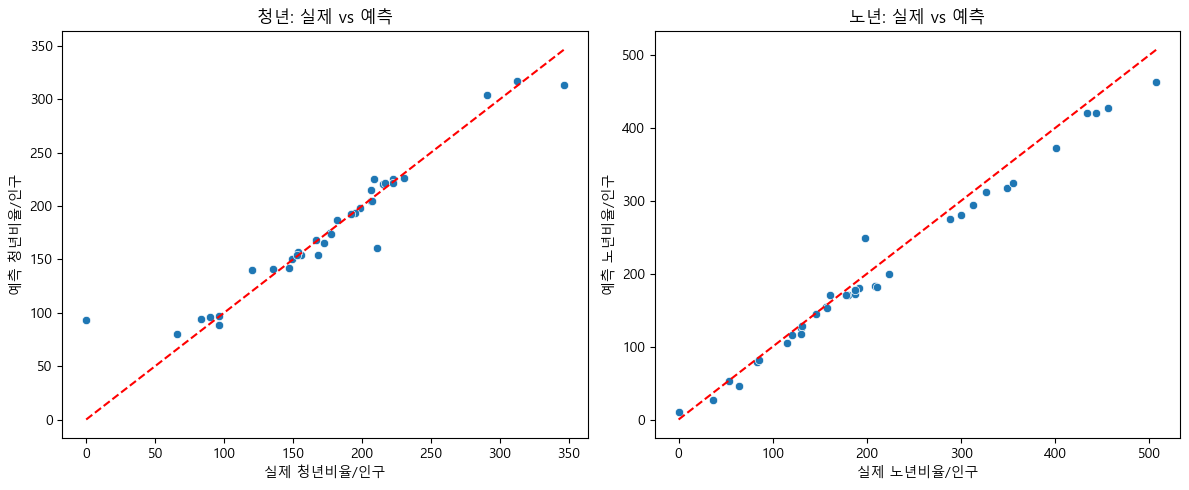

In [ ]:
plt.figure(figsize=(12,5))

# 청년
plt.subplot(1,2,1)
sns.scatterplot(x=y_test_y, y=pred_y)
plt.plot([y_test_y.min(), y_test_y.max()], [y_test_y.min(), y_test_y.max()], 'r--')
plt.xlabel("실제 청년비율/인구")
plt.ylabel("예측 청년비율/인구")
plt.title("청년: 실제 vs 예측")

# 노년
plt.subplot(1,2,2)
sns.scatterplot(x=y_test_o, y=pred_o)
plt.plot([y_test_o.min(), y_test_o.max()], [y_test_o.min(), y_test_o.max()], 'r--')
plt.xlabel("실제 노년비율/인구")
plt.ylabel("예측 노년비율/인구")
plt.title("노년: 실제 vs 예측")

plt.tight_layout()
plt.show()


In [ ]:
# ======================
# 1) 유틸
# ======================
def safe_read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8-sig", "cp949", "euc-kr", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc, sep=None, engine="python")
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, encoding="cp949", sep=None, engine="python")

def _normalize(colname: str) -> str:
    return re.sub(r"\s+", "", str(colname)).lower()

LAT_ALIASES = {"lat","latitude","위도","y","ycoord","y_coord","y좌표"}
LON_ALIASES = {"lon","lng","longitude","경도","x","xcoord","x_coord","x좌표"}

def find_latlon_columns(df: pd.DataFrame):
    norm_cols = {_normalize(c): c for c in df.columns}
    lat_col = None; lon_col = None
    for alias in LAT_ALIASES:
        if alias in norm_cols: lat_col = norm_cols[alias]; break
    for alias in LON_ALIASES:
        if alias in norm_cols: lon_col = norm_cols[alias]; break
    if lat_col is None:
        lat_col = next((c for c in df.columns if c in ["위도","Lat","LAT"]), None)
    if lon_col is None:
        lon_col = next((c for c in df.columns if c in ["경도","Lon","LON"]), None)
    return lat_col, lon_col

def rmse(a, b) -> float:
    return float(np.sqrt(mean_squared_error(a, b)))

def to_int64_nullable_nonneg(x):
    """Pandas Nullable 정수(Int64)로 안전 캐스팅(음수→0, 반올림)."""
    return pd.Series(x).clip(lower=0).round(0).astype("Int64")

# ======================
# 2) 5세구간 인구 로드/정규화
# ======================
fiveyears_files = glob.glob(PATHS["fiveyears"])
use_raw = False
if not fiveyears_files:
    alt_pattern = os.path.join(DATA_DIR, "연령별 인구수", "outputs_5y", "연령별인구_읍면동_5세구간_*.csv")
    fiveyears_files = glob.glob(alt_pattern)
    use_raw = True
    print(f"[WARN] 합계 파일 없음 → 성별 포함 원본 {len(fiveyears_files)}개로 대체")
if not fiveyears_files:
    raise FileNotFoundError("5세구간 파일을 찾지 못했습니다. 경로/파일명을 확인하세요.")

def norm_bin(s: str) -> str:
    if pd.isna(s): return s
    s = (str(s).strip()
         .replace(" ", "")
         .replace("~", "-").replace("～", "-")
         .replace("−", "-").replace("–", "-"))
    s = s.replace("05-09", "5-9").replace("5~9", "5-9")
    s = s.replace("10~14", "10-14").replace("10월14일", "10-14").replace("05월09일", "5-9")
    m = re.match(r"0*([0-9]{1,2})-0*([0-9]{1,2})", s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}-{hi}"
    if "85+" in s or "85이상" in s or (("85" in s) and ("+" in s)):
        return "85+"
    return s

def load_fiveyear_csv(fpath: str) -> pd.DataFrame:
    tmp = safe_read_table(fpath)
    bn = os.path.basename(fpath)
    m = re.search(r"(\d{6})", bn) or re.search(r"(\d{4})", bn)
    year = int(m.group(1)[:4]) if m else None
    tmp["연도"] = year

    rename_map = {}
    if "행정구역" in tmp.columns and "읍면동" not in tmp.columns:
        rename_map["행정구역"] = "읍면동"
    if "인구" in tmp.columns and "인구수" not in tmp.columns:
        rename_map["인구"] = "인구수"
    if rename_map: tmp = tmp.rename(columns=rename_map)

    if use_raw and "성별" in tmp.columns:
        tmp = tmp.groupby(["읍면동", "연령5세구간", "연도"], as_index=False)["인구수"].sum()

    tmp["연령5세구간"] = tmp["연령5세구간"].astype(str).map(norm_bin)
    return tmp[["읍면동", "연령5세구간", "인구수", "연도"]]

pop_full = pd.concat([load_fiveyear_csv(f) for f in fiveyears_files], ignore_index=True)

# 총인구
total_agg = pop_full.groupby(["읍면동", "연도"])["인구수"].sum().reset_index(name="총인구")

# 청년/노년 집계
def categorize_age(age_range: str):
    if age_range is None or pd.isna(age_range): return None
    s = str(age_range)
    if any(t in s for t in ["20-24", "25-29", "30-34"]): return "청년인구"
    if any(t in s for t in ["65-69", "70-74", "75-79", "80-84", "85+"]): return "노년인구"
    return None

tmp = pop_full.copy()
tmp["인구유형"] = tmp["연령5세구간"].map(categorize_age)
tmp = tmp.dropna(subset=["인구유형"])
young_old_agg = (tmp.groupby(["읍면동", "연도", "인구유형"])["인구수"]
                   .sum().unstack(fill_value=0).reset_index())
young_old_agg.columns.name = None

pop_agg = total_agg.merge(young_old_agg, on=["읍면동", "연도"], how="left").rename(columns={"읍면동":"EMD_KOR_NM"})
for c in ["청년인구","노년인구"]:
    if c not in pop_agg.columns: pop_agg[c] = 0

# ======================
# 3) 경계/면적 + 포인트 집계
# ======================
boundary_df = safe_read_table(PATHS["boundary_csv"])
if "_WKT" not in boundary_df.columns: raise KeyError("경계 CSV에 '_WKT' 필요")
if "EMD_KOR_NM" not in boundary_df.columns: raise KeyError("경계 CSV에 'EMD_KOR_NM' 필요")
boundary_df["geometry"] = boundary_df["_WKT"].apply(wkt.loads)
gdf_boundary = gpd.GeoDataFrame(boundary_df, geometry="geometry", crs="EPSG:4326")

# 면적(km²)
gdf_area = gdf_boundary.to_crs(epsg=5179)
gdf_boundary["area_km2"] = gdf_area.geometry.area / 1e6
area_df = gdf_boundary[["EMD_KOR_NM", "area_km2"]].drop_duplicates()

def process_spatial_data(file_path, count_col_name):
    if not os.path.exists(file_path):
        print(f"[WARN] 파일 없음: {file_path}"); return None
    try:
        df = safe_read_table(file_path)
        lat_col, lon_col = find_latlon_columns(df)
        if lat_col is None or lon_col is None:
            print(f"[WARN] {file_path} 위경도 컬럼 식별 실패"); return None
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326")
        sjoined = gpd.sjoin(gdf, gdf_boundary, how="inner", predicate="within")
        return sjoined.groupby("EMD_KOR_NM").size().reset_index(name=count_col_name)
    except Exception as e:
        print(f"[ERROR] {file_path} 처리 중 오류: {e}"); return None

univ_count     = process_spatial_data(PATHS["universities"], "대학수")
school_count   = process_spatial_data(PATHS["schools"],     "초중고수")
busstop_count  = process_spatial_data(PATHS["busstops"],    "버스정류장수")
hospital_count = process_spatial_data(PATHS["hospitals"],   "병원수")

# ======================
# 4) 과거 데이터 결합/피처
# ======================
emd_unique  = pop_agg["EMD_KOR_NM"].unique()
year_unique = sorted(pop_agg["연도"].unique())
base_df = pd.DataFrame(list(itertools.product(emd_unique, year_unique)), columns=["EMD_KOR_NM","연도"])

df = base_df.merge(pop_agg, on=["EMD_KOR_NM","연도"], how="left")
for add_df in [univ_count, school_count, busstop_count, hospital_count]:
    if add_df is not None:
        df = df.merge(add_df, on="EMD_KOR_NM", how="left")
df = df.merge(area_df, on="EMD_KOR_NM", how="left")

# 밀도 & NaN 보정(면적 0 지역)
for col in ["대학수","초중고수","버스정류장수","병원수"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[f"{col}_밀도"] = df[col] / df["area_km2"].replace(0, np.nan)
density_cols = [c for c in df.columns if c.endswith("_밀도")]
df[density_cols] = df[density_cols].fillna(0)

# 비율(천명당)
df["청년비율_천명"] = 1000.0 * df["청년인구"] / df["총인구"]
df["노년비율_천명"] = 1000.0 * df["노년인구"] / df["총인구"]

# lag1 (읍면동별 전년도)
df = df.sort_values(["EMD_KOR_NM","연도"])
for c in ["총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]:
    df[f"lag1_{c}"] = df.groupby("EMD_KOR_NM")[c].shift(1)

# == 학습 범위: 관측치가 2025년까지라고 가정하고, 학습/백테스트 anchor_end=2025 ==
max_obs_year = df["연도"].max()
anchor_end = min(2025, int(max_obs_year))  # 실제 파일이 2025 이전에 끊겨도 안전

# 연도 정규화: 예측(2028)까지 포함해 0~1
min_year = df["연도"].min()
max_year_all = max(anchor_end, max(FUTURE_YEARS))
denom = max(1, (max_year_all - min_year))
df["연도_norm"] = (df["연도"] - min_year) / denom

# 수치 결측 0
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(0)

# ======================
# 5) 피처 빌더 (비율용 / 총인구용)
# ======================
def prune_constant_cols(X_df: pd.DataFrame):
    nunique = X_df.nunique(dropna=False)
    keep = nunique[nunique >= 2].index.tolist()
    return X_df[keep], keep

def build_feature_matrix_rate(df_sub: pd.DataFrame):
    """원-핫, 비율 타깃(천명당)용 X/y/feat_keep."""
    df_hot = pd.get_dummies(df_sub, columns=["EMD_KOR_NM"], prefix="읍면동")
    target_y, target_o = "청년비율_천명", "노년비율_천명"
    exclude_cols = set(["연도", "총인구", "청년인구", "노년인구"])
    feat_cols = [c for c in df_hot.columns if c not in exclude_cols and c not in [target_y, target_o]]
    X = df_hot[feat_cols].copy()
    y_y = df_hot[target_y].values
    y_o = df_hot[target_o].values
    X, keep = prune_constant_cols(X)
    return X, y_y, y_o, keep

def build_feature_matrix_total(df_sub: pd.DataFrame):
    """
    총인구 타깃용 X/y/feat_keep.
    누수 방지를 위해 현재 연도 '청년/노년 비율/인원'은 제외하고,
    lag1_* / 연도_norm / 면적/시설/밀도/읍면동 원-핫 등을 사용.
    """
    df_hot = pd.get_dummies(df_sub, columns=["EMD_KOR_NM"], prefix="읍면동")
    exclude_now = {"청년비율_천명","노년비율_천명","청년인구","노년인구"}  # 현재 연도 값 제외
    base_excl = {"연도","총인구"}  # 타깃/연도
    exclude_cols = base_excl.union(exclude_now)
    feat_cols = [c for c in df_hot.columns if c not in exclude_cols]
    X = df_hot[feat_cols].copy()
    y = df_hot["총인구"].values
    X, keep = prune_constant_cols(X)
    return X, y, keep

def make_rf():
    return RandomForestRegressor(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=MAX_LEAF,
        max_features="sqrt",
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

# ======================
# 6) 정적 피처(면적/시설/밀도)
# ======================
def build_static_future(area_df, *count_dfs):
    static_f = area_df.copy()
    names = ["대학수", "초중고수", "버스정류장수", "병원수"]
    for add_df, nm in zip(count_dfs, names):
        if add_df is not None:
            static_f = static_f.merge(add_df, on="EMD_KOR_NM", how="left")
        else:
            static_f[nm] = 0
    for col in names:
        static_f[col] = static_f[col].fillna(0)
        static_f[f"{col}_밀도"] = static_f[col] / static_f["area_km2"].replace(0, np.nan)
    dens = [c for c in static_f.columns if c.endswith("_밀도")]
    static_f[dens] = static_f[dens].fillna(0)
    return static_f

static_future_all = build_static_future(area_df, univ_count, school_count, busstop_count, hospital_count)
static_future_all = static_future_all.drop_duplicates("EMD_KOR_NM").reset_index(drop=True)

# 최신 실제(≤anchor_end): 초기 lag 상태
latest_actual_anchor = (
    df[df["연도"] <= anchor_end]
      .sort_values(["EMD_KOR_NM","연도"])
      .groupby("EMD_KOR_NM").tail(1)
      [["EMD_KOR_NM","총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]]
      .rename(columns={
          "총인구":"lag_총인구",
          "청년인구":"lag_청년인구",
          "노년인구":"lag_노년인구",
          "청년비율_천명":"lag_청년비율",
          "노년비율_천명":"lag_노년비율"
      })
)

latest_actual_anchor_state = (
    static_future_all[["EMD_KOR_NM"]]
      .merge(latest_actual_anchor, on="EMD_KOR_NM", how="left")
      .fillna(0)
      .set_index("EMD_KOR_NM")
)

# ======================
# 7) 순차(autoregressive) 예측 함수 (총인구=RF)
# ======================
def forecast_autoreg_rf_total(df_all, feat_keep_rate, rf_y, rf_o,
                              feat_keep_tot, rf_tot,
                              start_state_df, static_future, future_years,
                              min_year, denom):
    """
    - rf_y, rf_o: 비율(천명당) 모델
    - rf_tot: 총인구 모델
    - feat_keep_rate / feat_keep_tot: 각 모델의 학습 피처 컬럼 리스트(순서 포함)
    - start_state_df: index=EMD, ['lag_총인구','lag_청년인구','lag_노년인구','lag_청년비율','lag_노년비율']
    """
    static_f = static_future.drop_duplicates("EMD_KOR_NM").copy()
    state = (static_f[["EMD_KOR_NM"]]
             .merge(start_state_df.reset_index(), on="EMD_KOR_NM", how="left")
             .fillna(0)
             .set_index("EMD_KOR_NM"))

    recs = []

    for yr in future_years:
        fut = static_f.copy()
        fut["연도"] = yr

        # state 정렬/확장
        idx = fut["EMD_KOR_NM"].values
        state = (static_f[["EMD_KOR_NM"]]
                 .merge(state.reset_index(), on="EMD_KOR_NM", how="left")
                 .fillna(0)
                 .set_index("EMD_KOR_NM"))
        state = state.reindex(idx).fillna(0)

        # state 붙이기
        fut = fut.merge(state.reset_index(), on="EMD_KOR_NM", how="left", sort=False)

        # 스케일
        fut["연도_norm"] = (yr - min_year) / denom

        # 자리
        fut["청년비율_천명"] = 0.0
        fut["노년비율_천명"] = 0.0

        # lag1_* 만들기
        fut["lag1_총인구"]        = fut["lag_총인구"].fillna(0)
        fut["lag1_청년인구"]      = fut["lag_청년인구"].fillna(0)
        fut["lag1_노년인구"]      = fut["lag_노년인구"].fillna(0)
        fut["lag1_청년비율_천명"] = fut["lag_청년비율"].fillna(0)
        fut["lag1_노년비율_천명"] = fut["lag_노년비율"].fillna(0)

        # 원-핫
        fut_hot = pd.get_dummies(fut, columns=["EMD_KOR_NM"], prefix="읍면동")

        # 1) 총인구 예측
        X_fut_tot = fut_hot.reindex(columns=feat_keep_tot, fill_value=0)
        pred_tot = rf_tot.predict(X_fut_tot.values)
        # 폴백: 결측 → lag_총인구, 최소 1로 클리핑
        if isinstance(pred_tot, pd.Series):
            pred_tot = pred_tot.values
        pred_tot = np.where(np.isnan(pred_tot), fut["lag_총인구"].values, pred_tot)
        pred_tot = np.clip(pred_tot, 1.0, None)
        fut["예상_총인구"] = pred_tot

        # 2) 비율 예측
        X_fut_rate = fut_hot.reindex(columns=feat_keep_rate, fill_value=0)
        pred_y = rf_y.predict(X_fut_rate.values)
        pred_o = rf_o.predict(X_fut_rate.values)

        # Count 환산
        est_y_cnt = (pred_y / 1000.0) * fut["예상_총인구"].values
        est_o_cnt = (pred_o / 1000.0) * fut["예상_총인구"].values

        # 결과 저장
        recs.append(pd.DataFrame({
            "EMD_KOR_NM": fut["읍면동_"].columns if False else fut_hot.filter(like="읍면동_", axis=1).columns[:1],  # dummy to keep editor quiet
        }))
        recs[-1] = pd.DataFrame({
            "EMD_KOR_NM": fut["EMD_KOR_NM"].values if "EMD_KOR_NM" in fut.columns else fut.merge(static_f, left_index=True, right_index=True)["EMD_KOR_NM"].values,
            "연도": yr,
            "예상_총인구":       to_int64_nullable_nonneg(fut["예상_총인구"].values),
            "예상_청년비율_천명": np.round(pred_y, 2),
            "예상_노년비율_천명": np.round(pred_o, 2),
            "예상_청년인구_명":  to_int64_nullable_nonneg(est_y_cnt),
            "예상_노년인구_명":  to_int64_nullable_nonneg(est_o_cnt),
        })

        # 다음 해 state 업데이트
        state.loc[idx, "lag_총인구"]   = fut["예상_총인구"].values
        state.loc[idx, "lag_청년비율"] = pred_y
        state.loc[idx, "lag_노년비율"] = pred_o
        state.loc[idx, "lag_청년인구"] = est_y_cnt
        state.loc[idx, "lag_노년인구"] = est_o_cnt

    return pd.concat(recs, ignore_index=True)

# ======================
# 8) 백테스트(3년 앞) RMSE (총인구=RF)
# ======================
def compute_rmse_for(pred_df, actual_df, on_cols=("EMD_KOR_NM","연도"),
                     pred_rate_cols=("예상_청년비율_천명","예상_노년비율_천명"),
                     pred_cnt_cols=("예상_청년인구_명","예상_노년인구_명")):
    merged = pred_df.merge(actual_df, on=list(on_cols), how="inner")
    y_rate_y = merged["청년비율_천명"].values.astype(float)
    y_rate_o = merged["노년비율_천명"].values.astype(float)
    y_cnt_y  = merged["청년인구"].values.astype(float)
    y_cnt_o  = merged["노년인구"].values.astype(float)

    p_rate_y = merged[pred_rate_cols[0]].values.astype(float)
    p_rate_o = merged[pred_rate_cols[1]].values.astype(float)
    p_cnt_y  = merged[pred_cnt_cols[0]].values.astype(float)
    p_cnt_o  = merged[pred_cnt_cols[1]].values.astype(float)

    return {
        "RMSE_RATE_청년": rmse(y_rate_y, p_rate_y),
        "RMSE_RATE_노년": rmse(y_rate_o, p_rate_o),
        "RMSE_CNT_청년" : rmse(y_cnt_y,  p_cnt_y),
        "RMSE_CNT_노년" : rmse(y_cnt_o,  p_cnt_o),
        "N": len(merged)
    }

def backtest_three_year_rf_total(df_all, static_future, min_year, anchor_end):
    """
    t를 min_year..anchor_end-3까지 움직이며:
      - train: ≤ t
      - predict: t+1..t+3 (autoregressive)
      - 총인구: RF 모델로 예측
      - 초기 state: 각 읍면동 t년 실제
    """
    results = []
    emd_list = sorted(df_all["EMD_KOR_NM"].unique())

    for t in range(int(min_year)+1, int(anchor_end)-2):  # t+3 ≤ anchor_end
        train_t = df_all[df_all["연도"] <= t].copy()
        if train_t.empty: continue

        # 비율용
        X_rate_t, y_y_t, y_o_t, keep_rate_t = build_feature_matrix_rate(train_t)
        rf_y_t = make_rf().fit(X_rate_t.values, y_y_t)
        rf_o_t = make_rf().fit(X_rate_t.values, y_o_t)

        # 총인구용
        X_tot_t, y_tot_t, keep_tot_t = build_feature_matrix_total(train_t)
        rf_tot_t = make_rf().fit(X_tot_t.values, y_tot_t)

        # 초기 state(t년 실제)
        state_t = (train_t.sort_values(["EMD_KOR_NM","연도"])
                    .groupby("EMD_KOR_NM").tail(1)
                    [["EMD_KOR_NM","총인구","청년인구","노년인구","청년비율_천명","노년비율_천명"]]
                    .rename(columns={
                        "총인구":"lag_총인구",
                        "청년인구":"lag_청년인구",
                        "노년인구":"lag_노년인구",
                        "청년비율_천명":"lag_청년비율",
                        "노년비율_천명":"lag_노년비율"
                    })
                  )
        state_t = (static_future[["EMD_KOR_NM"]]
                   .merge(state_t, on="EMD_KOR_NM", how="left")
                   .fillna(0).set_index("EMD_KOR_NM"))

        years_pred = [t+1, t+2, t+3]
        preds_t = forecast_autoreg_rf_total(
            df_all=train_t,
            feat_keep_rate=keep_rate_t, rf_y=rf_y_t, rf_o=rf_o_t,
            feat_keep_tot=keep_tot_t, rf_tot=rf_tot_t,
            start_state_df=state_t, static_future=static_future,
            future_years=years_pred, min_year=min_year, denom=(max(years_pred)-min_year if (max(years_pred)-min_year)>0 else 1)
        )

        actual_t = (df_all[df_all["연도"].isin(years_pred)]
                    [["EMD_KOR_NM","연도","청년비율_천명","노년비율_천명","청년인구","노년인구"]]).copy()

        metrics = compute_rmse_for(preds_t, actual_t)
        metrics.update({"anchor_t": t})
        results.append(metrics)

    if not results:
        return None
    res_df = pd.DataFrame(results)
    agg = {
        "RMSE_RATE_청년": res_df["RMSE_RATE_청년"].mean(),
        "RMSE_RATE_노년": res_df["RMSE_RATE_노년"].mean(),
        "RMSE_CNT_청년" : res_df["RMSE_CNT_청년"].mean(),
        "RMSE_CNT_노년" : res_df["RMSE_CNT_노년"].mean(),
        "splits": len(res_df)
    }
    return agg, res_df

# ======================
# 9) 학습(≤2025) → 2026~2028 예측 (총인구=RF)
# ======================
train_anchor = df[df["연도"] <= anchor_end].copy()

# 비율 모델
X_rate_all, y_y_all, y_o_all, keep_rate_cols = build_feature_matrix_rate(train_anchor)
rf_y_all = make_rf().fit(X_rate_all.values, y_y_all)
rf_o_all = make_rf().fit(X_rate_all.values, y_o_all)

# 총인구 모델
X_tot_all, y_tot_all, keep_tot_cols = build_feature_matrix_total(train_anchor)
rf_tot_all = make_rf().fit(X_tot_all.values, y_tot_all)

# 예측
preds_2026_2028 = forecast_autoreg_rf_total(
    df_all=train_anchor,
    feat_keep_rate=keep_rate_cols, rf_y=rf_y_all, rf_o=rf_o_all,
    feat_keep_tot=keep_tot_cols, rf_tot=rf_tot_all,
    start_state_df=latest_actual_anchor_state, static_future=static_future_all,
    future_years=FUTURE_YEARS, min_year=min_year, denom=denom
)

# 저장
save_path = os.path.join(DATA_DIR, "예측_청년_노년_2026-2028_RF.csv")
preds_2026_2028.to_csv(save_path, index=False, encoding="utf-8-sig")
print(f"[SAVE] 2026~2028 예측 결과: {save_path}")
print(preds_2026_2028.head(10))

# ======================
# 10) RMSE 계산
# (A) 백테스트(롤링-오리진 3년 앞) 평균 — 총인구=RF
# ======================
bt = backtest_three_year_rf_total(df_all=df, static_future=static_future_all, min_year=min_year, anchor_end=anchor_end)
if bt is None:
    print("[INFO] 백테스트를 수행할 충분한 연도 폭이 없습니다.")
else:
    agg_bt, detail_bt = bt
    print("\n[백테스트: 3년 앞 예측 평균 RMSE (총인구=RF)]")
    print(f"  RATE 청년: {agg_bt['RMSE_RATE_청년']:.2f}")
    print(f"  RATE 노년: {agg_bt['RMSE_RATE_노년']:.2f}")
    print(f"  CNT  청년: {agg_bt['RMSE_CNT_청년']:.2f}")
    print(f"  CNT  노년: {agg_bt['RMSE_CNT_노년']:.2f}")
    print(f"  splits: {agg_bt['splits']}")

# ======================
# 11) (B) 실제 2026–2028이 있으면 해당 구간 RMSE
# ======================
actual_future = df[df["연도"].isin(FUTURE_YEARS)][["EMD_KOR_NM","연도","청년비율_천명","노년비율_천명","청년인구","노년인구"]].copy()
if len(actual_future) > 0:
    met_future = compute_rmse_for(preds_2026_2028, actual_future)
    print("\n[실제 2026–2028 RMSE]")
    print(f"  RATE 청년: {met_future['RMSE_RATE_청년']:.2f}")
    print(f"  RATE 노년: {met_future['RMSE_RATE_노년']:.2f}")
    print(f"  CNT  청년: {met_future['RMSE_CNT_청년']:.2f}")
    print(f"  CNT  노년: {met_future['RMSE_CNT_노년']:.2f}")
    print(f"  N: {met_future['N']}")
else:
    print("\n[알림] 2026–2028 실제값이 없어 해당 구간 RMSE는 계산하지 않았습니다. (백테스트 RMSE 참고)")


2020~2028 변화율이 큰 읍면동 top3
    읍면동         총인구        청년인구       노년인구        변화율합
52  풍세면  120.528211  126.647564  73.837667  321.013443
16  불당동  -77.504537  -93.793310 -52.312004  223.609850
32  쌍용동  -68.644872  -84.482170 -62.911638  216.038679


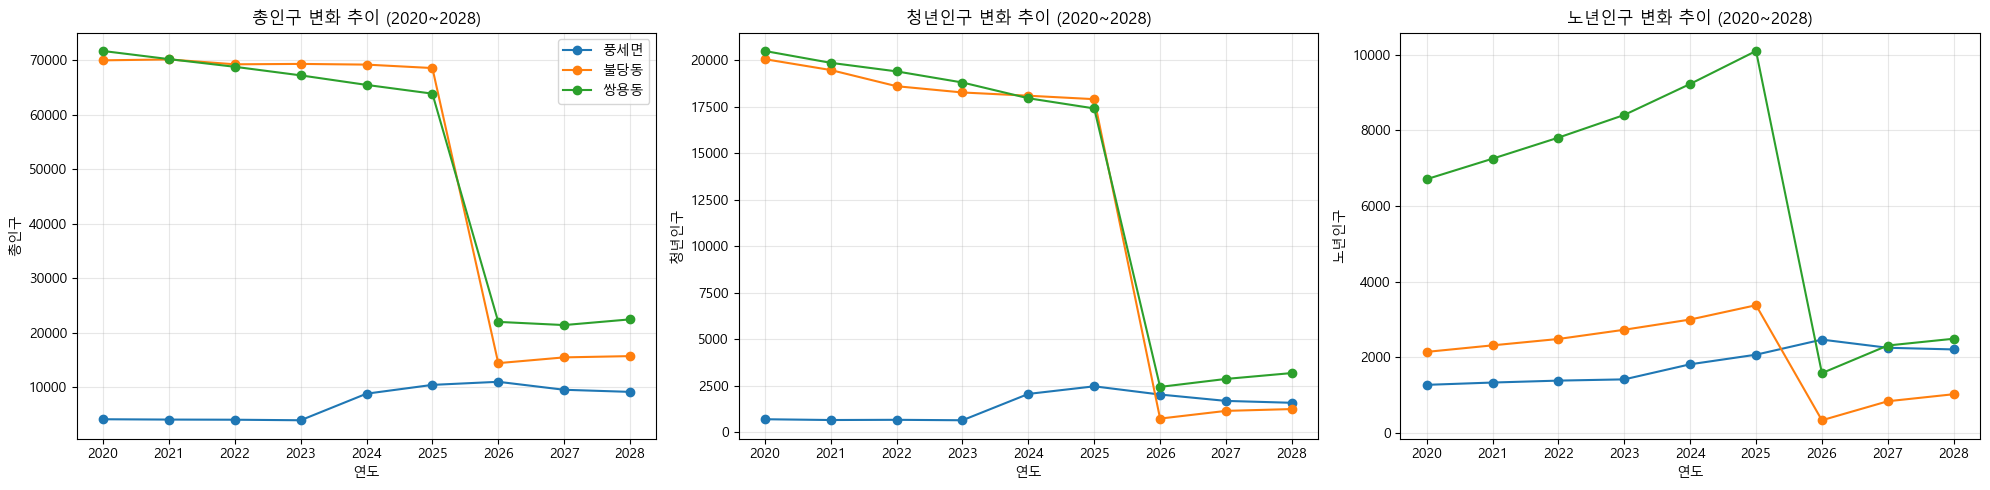

In [ ]:
# ----------------------
# 0. 동 합치기 규칙 정의
# ----------------------
merge_rules = {
    "불당동": ["불당1동", "불당2동"],
    "쌍용동": ["쌍용1동", "쌍용2동", "쌍용3동"],
    "부성동": ["부성1동", "부성2동"],
    "원성동": ["원성1동", "원성2동"]
}

def unify_region(df):
    """merge_rules에 따라 읍면동 합치기"""
    for unified, sublist in merge_rules.items():
        mask = df["읍면동"].isin(sublist)
        if mask.any():
            summed = (
                df.loc[mask]
                .groupby("연도")
                .sum(numeric_only=True)
                .reset_index()
            )
            summed["읍면동"] = unified
            df = pd.concat([df.loc[~mask], summed], ignore_index=True)
    return df

# ----------------------
# 1. 실제 데이터 (2020~2025) 합치기
# ----------------------
files = glob.glob(r"C:\Users\yeye0\Desktop\천안시\변수데이터\나이대별\연령별인구_*.csv")

# 청년/노년 구간
youth_bins = ["15-19", "20-24", "25-29", "30-34"]
old_bins = ["65-69", "70-74", "75-79", "80-84", "85+"]

actual_list = []
for f in files:
    year = f.split("_")[-1].replace(".csv","")[:4]  # 파일명에서 연도 추출 (예: 202107 -> 2021)
    df = pd.read_csv(f)
    df["연도"] = int(year)
    # 집계
    agg = df.groupby("읍면동").apply(
        lambda g: pd.Series({
            "총인구": g["인구수"].sum(),
            "청년인구": g[g["연령5세구간"].isin(youth_bins)]["인구수"].sum(),
            "노년인구": g[g["연령5세구간"].isin(old_bins)]["인구수"].sum()
        })
    ).reset_index()
    agg["연도"] = int(year)
    actual_list.append(agg)

agg_actual = pd.concat(actual_list, ignore_index=True)
agg_actual = unify_region(agg_actual)

# ----------------------
# 2. 예측 데이터 (2026~2028)
# ----------------------
pred = pd.read_csv(r"C:\Users\yeye0\Desktop\천안시\변수데이터\예측_청년_노년_2026-2028.csv")

pred = pred.rename(columns={
    "EMD_KOR_NM": "읍면동",
    "예상_총인구": "총인구",
    "예상_청년인구_명": "청년인구",
    "예상_노년인구_명": "노년인구"
})

pred = unify_region(pred)

# ----------------------
# 3. 합치기
# ----------------------
df = pd.concat([
    agg_actual[["읍면동","연도","총인구","청년인구","노년인구"]],
    pred[["읍면동","연도","총인구","청년인구","노년인구"]]
], ignore_index=True)

# ----------------------
# 4. 변화율 계산 (2020 vs 2028)
# ----------------------
base = df[df["연도"] == 2020].set_index("읍면동")
future = df[df["연도"] == 2028].set_index("읍면동")

change = ((future[["총인구","청년인구","노년인구"]] - base[["총인구","청년인구","노년인구"]]) 
          / base[["총인구","청년인구","노년인구"]] * 100).reset_index()

change["변화율합"] = change[["총인구","청년인구","노년인구"]].abs().sum(axis=1)

# ----------------------
# 5. TOP3 선정
# ----------------------
top3 = change.nlargest(3, "변화율합")
print("2020~2028 변화율이 큰 읍면동 top3")
print(top3)

# ----------------------
# 6. 선그래프 (1행 3열)
# ----------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

cols = ["총인구", "청년인구", "노년인구"]

for i, col in enumerate(cols):
    ax = axes[i]
    for emd in top3["읍면동"]:
        subset = df[df["읍면동"] == emd].sort_values("연도")
        ax.plot(subset["연도"], subset[col], marker="o", label=emd)
    ax.set_title(f"{col} 변화 추이 (2020~2028)")
    ax.set_xlabel("연도")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc="upper right")  # 첫 번째 그래프에만 범례

plt.tight_layout()
plt.show()

2020~2028 변화율이 큰 읍면동 top3 (불당동, 쌍용동 제외)
    읍면동         총인구        청년인구       노년인구        변화율합
52  풍세면  120.528211  126.647564  73.837667  321.013443
7   목천읍   -7.665951  -36.002261  37.444812   81.113024
10  백석동   -3.822839  -32.784417  44.145420   80.752677


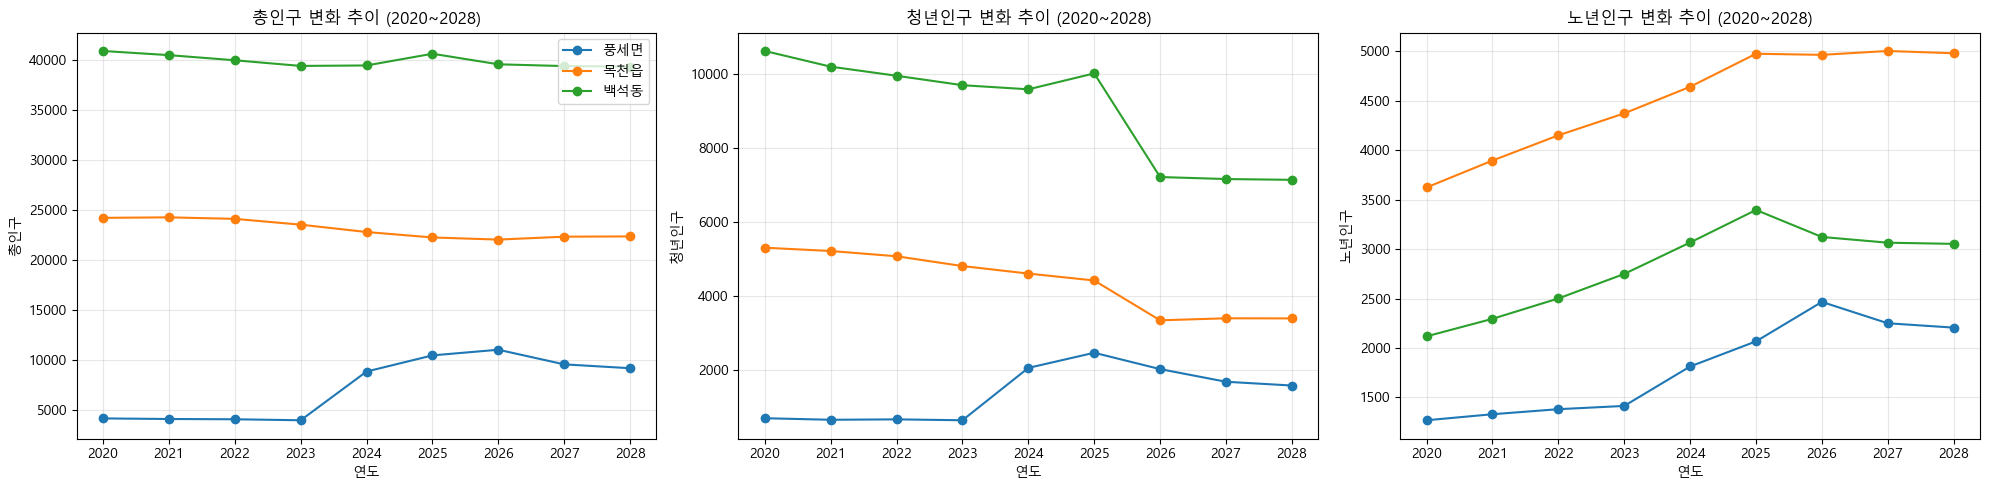

In [ ]:
# ----------------------
# 0. 동 합치기 규칙 정의
# ----------------------
merge_rules = {
    "불당동": ["불당1동", "불당2동"],
    "쌍용동": ["쌍용1동", "쌍용2동", "쌍용3동"],
    "부성동": ["부성1동", "부성2동"],
    "원성동": ["원성1동", "원성2동"]
}

def unify_region(df):
    """merge_rules에 따라 읍면동 합치기"""
    for unified, sublist in merge_rules.items():
        mask = df["읍면동"].isin(sublist)
        if mask.any():
            summed = (
                df.loc[mask]
                .groupby("연도")
                .sum(numeric_only=True)
                .reset_index()
            )
            summed["읍면동"] = unified
            df = pd.concat([df.loc[~mask], summed], ignore_index=True)
    return df

# ----------------------
# 1. 실제 데이터 (2020~2025) 합치기
# ----------------------
files = glob.glob(r"C:\Users\yeye0\Desktop\천안시\변수데이터\나이대별\연령별인구_*.csv")

# 청년/노년 구간
youth_bins = ["15-19", "20-24", "25-29", "30-34"]
old_bins = ["65-69", "70-74", "75-79", "80-84", "85+"]

actual_list = []
for f in files:
    year = f.split("_")[-1].replace(".csv","")[:4]  # 파일명에서 연도 추출 (예: 202107 -> 2021)
    df = pd.read_csv(f)
    df["연도"] = int(year)
    # 집계
    agg = df.groupby("읍면동").apply(
        lambda g: pd.Series({
            "총인구": g["인구수"].sum(),
            "청년인구": g[g["연령5세구간"].isin(youth_bins)]["인구수"].sum(),
            "노년인구": g[g["연령5세구간"].isin(old_bins)]["인구수"].sum()
        })
    ).reset_index()
    agg["연도"] = int(year)
    actual_list.append(agg)

agg_actual = pd.concat(actual_list, ignore_index=True)
agg_actual = unify_region(agg_actual)

# ----------------------
# 2. 예측 데이터 (2026~2028)
# ----------------------
pred = pd.read_csv(r"C:\Users\yeye0\Desktop\천안시\변수데이터\예측_청년_노년_2026-2028.csv")

pred = pred.rename(columns={
    "EMD_KOR_NM": "읍면동",
    "예상_총인구": "총인구",
    "예상_청년인구_명": "청년인구",
    "예상_노년인구_명": "노년인구"
})

pred = unify_region(pred)

# ----------------------
# 3. 합치기
# ----------------------
df = pd.concat([
    agg_actual[["읍면동","연도","총인구","청년인구","노년인구"]],
    pred[["읍면동","연도","총인구","청년인구","노년인구"]]
], ignore_index=True)

# ----------------------
# 4. 변화율 계산 (2020 vs 2028)
# ----------------------
base = df[df["연도"] == 2020].set_index("읍면동")
future = df[df["연도"] == 2028].set_index("읍면동")

change = ((future[["총인구","청년인구","노년인구"]] - base[["총인구","청년인구","노년인구"]]) 
          / base[["총인구","청년인구","노년인구"]] * 100).reset_index()

change["변화율합"] = change[["총인구","청년인구","노년인구"]].abs().sum(axis=1)

# ----------------------
# 5. 불당동, 쌍용동 제외 후 top3 선정
# ----------------------
exclude = ["불당동", "쌍용동"]
change_filtered = change[~change["읍면동"].isin(exclude)]

top3 = change_filtered.nlargest(3, "변화율합")

print("2020~2028 변화율이 큰 읍면동 top3 (불당동, 쌍용동 제외)")
print(top3)

# ----------------------
# 6. 선그래프 (1행 3열)
# ----------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

cols = ["총인구", "청년인구", "노년인구"]

for i, col in enumerate(cols):
    ax = axes[i]
    for emd in top3["읍면동"]:
        subset = df[df["읍면동"] == emd].sort_values("연도")
        ax.plot(subset["연도"], subset[col], marker="o", label=emd)
    ax.set_title(f"{col} 변화 추이 (2020~2028)")
    ax.set_xlabel("연도")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc="upper right")  # 첫 번째 그래프에만 범례

plt.tight_layout()
plt.show()